<a href="https://colab.research.google.com/github/KasiaLewandowska/Analiza-portfelowa-spolek-energetycznych/blob/main/my_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Analiza portfelowa spółek energetycznych**
Katarzyna Lewandowska, Max Manikowski, Krzysztof Niedziejko

## Wprowadzenie

W naszej dokumentacji przedstawimy projekt dotyczący analizy portfelowej z wykorzystaniem uczenia maszynowego dla pięciu spółek branży energetycznej:
- Kombinat Górniczo-Hutniczy Miedzi (**KGHM**)

  <img src="https://upload.wikimedia.org/wikipedia/commons/1/19/Kghm_nowe_logo.svg" width="200">

<br>

- LW Bogdanka (**LWB**)

  <img src="https://upload.wikimedia.org/wikipedia/commons/8/8f/LWBogdanka_logo.png" width="200">

<br>

- Jastrzębska Spółka Węglowa (**JSW**)

  <img src="https://uksw.edu.pl/images/aktualnosci/spolka-weglowa.jpg" width="200">

<br>

- Gazprom (**GAZP**)

  <img src="https://upload.wikimedia.org/wikipedia/commons/4/42/Gazprom_logo.svg" width="200">

<br>

- ExxonMobil Corporation (**XOM**)

  <img src="https://upload.wikimedia.org/wikipedia/commons/1/18/Exxon_Mobil_Logo.svg" width="200">

<br>

Trzy pierwsze są spółkami polskimi, a dwie ostatnie zagranicznymi. Celem projektu jest zastosowanie technik analizy danych do oceny atrakcyjności portfela inwestycyjnego, a także ocena sytuacji wybranych spółek i ich porównanie.

Branża energetyczna jest jedną z najważniejszych w gospodarce oraz stanowi filar bezpieczeństwa kraju. Wybrane przez nas spółki mają duże znaczenie na rynku energetycznym w Polsce i na świecie.

**JSW** to czołowy producent węgla kokosowego w Europie i istotna firma górnicza w Polsce. **KGHM** – jedna z największych spółek górniczo-hutniczych na świecie, zajmująca się wydobyciem i przetwórstwem miedzi oraz innych metali. **LW Bogdanka** to firma, wydobywająca węgiel kamienny. W ostatnim czasie odnotowała wysoką stopę zwrotu dla inwestorów. Działalność **Gazpromu** związana jest z wydobyciem i produkcją gazu ziemnego oraz jego przesyłem. Gazprom to kluczowy gracz na rynku produkcji gazu, o czym mieszkańcy Europy mogli szczególnie przekonać się od czasu wybuchu wojny rosyjsko-ukraińskiej. **Exxon Mobil** jest z kolei amerykańską firmą zajmującą się przetwórstwem ropy naftowej i gazu ziemnego.

##Instalacja środowiska

In [ ]:
# %cd /content
# !rm ta-lib-*-src.tar.gz
# !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz #pobranie archiwum źródłowego ta-lib
# !tar -xzf ta-lib-0.4.0-src.tar.gz #rozpakowanie pliku ta-lib-0.4.0-src.tar.gz, flagi -xzf oznaczają, że plik ma zostać rozpakowany (x), jest skompresowany gzipem (z) i jest plikiem tar (f).
# # przejście do katalogu ta-lib:
# %cd ta-lib
# # uruchomienie skryptu konfiguracyjnego:
# !./configure --prefix=/usr
# # kompilacja kodu źródłowego:
# !make
# # instalacja ta-lib w /usr:
# !make install

In [ ]:
# # instalacja bibliotek python:
# !pip install seaborn-qqplot
# !pip install ydata_profiling
# !python3 -m pip install TA-Lib
# !pip install pmdarima

## Wizualizacja notowań spółek

Na potrzeby projektu zebrano dane dotyczące dziennej wartości notowań powyższych spółek w ciągu 5 lat od 13 marca 2018 do 13 marca 2023. Dane dla polskich firm pobrano ze strony stooq.pl, a w celu pozyskania danych firm zagranicznych skorzystaliśmy z zasobów dostępnych na stronie investing.com.

Przygotowanie bibliotek

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import math
import numpy as np

from scipy import stats

from scipy.stats import mode, norm, jarque_bera, chisquare, shapiro, kurtosistest, ttest_1samp

import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot

#from seaborn_qqplot import pplot
from statsmodels.tsa.stattools import adfuller

#from ydata_profiling import ProfileReport

import statsmodels.api as sm

In [ ]:
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.datasets import make_classification
from sklearn import metrics
from imblearn.pipeline import Pipeline

from sklearn.metrics import mean_absolute_error 
from sklearn.model_selection import GridSearchCV

Zdefiniowanie funkcji wyświetlających notowania spółek w postaci dataframe'u i na wykresach

In [ ]:
def notowania_dataframe(spolka, y):
  spolka_dane = pd.read_csv(f'/content/{spolka}.csv')
  spolka_dane = spolka_dane[['Data', y]]
  spolka_dane = spolka_dane.rename(columns={y: spolka})
  return spolka_dane

In [ ]:
def notowania_wykresy(spolka, color):
    fig, ax = plt.subplots(figsize=(18, 5))
    spolka.plot(x='Data', y=spolka.columns[1], kind='line', ax=ax, color=color)
    ax.set_xlabel('Data')
    ax.set_ylabel('Cena zamknięcia')
    plt.show()

In [ ]:
def wartosci_odstajace(df):
  srednia = df.iloc[:,1].mean()
  odchylenie = df.iloc[:, 1].std()
  odstajace = df[~((df.iloc[:, 1] > (srednia - 3 * odchylenie)) & (df.iloc[:, 1] < (srednia + 3 * odchylenie)))] 
  print(odstajace)

### KGHM

In [ ]:
spolka1 = notowania_dataframe('kgh', 'Zamkniecie')
spolka1['Data'] = pd.to_datetime(spolka1['Data'], format='%Y-%m-%d')
print(spolka1.isnull().sum())
spolka1

Data    0
kgh     0
dtype: int64


Data       kgh
0    2018-03-13   98.8252
1    2018-03-14   99.6408
2    2018-03-15   98.9223
3    2018-03-16   97.3786
4    2018-03-19   91.6136
...         ...       ...
1245 2023-03-07  125.8500
1246 2023-03-08  126.0000
1247 2023-03-09  121.9000
1248 2023-03-10  121.4500
1249 2023-03-13  119.5500

[1250 rows x 2 columns]

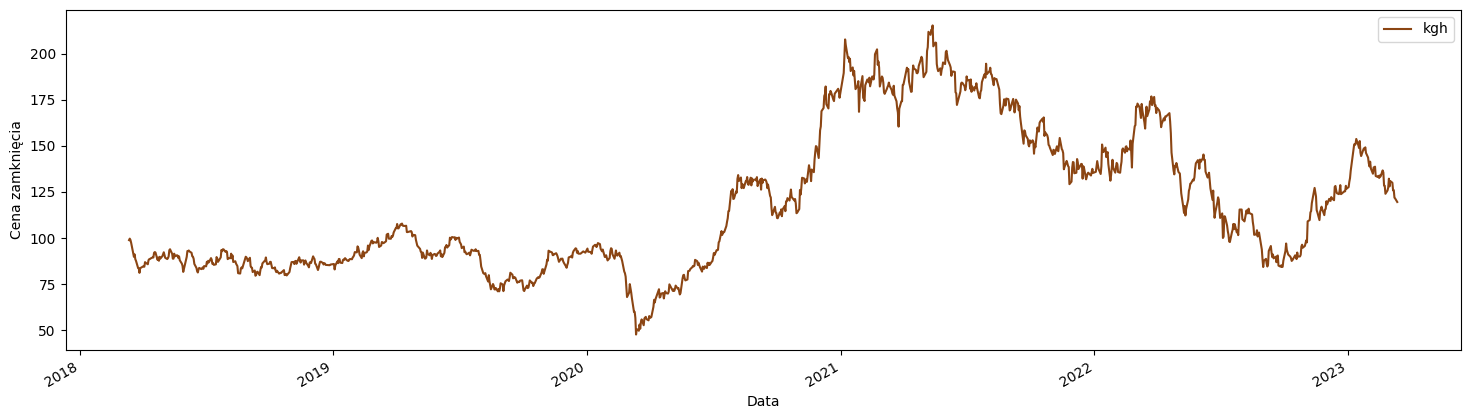

In [ ]:
notowania_wykresy(spolka1, 'saddlebrown')

### LWB

In [ ]:
spolka2 = notowania_dataframe('lwb', 'Zamkniecie')
spolka2['Data'] = pd.to_datetime(spolka2['Data'], format='%Y-%m-%d')
spolka2

Data      lwb
0    2018-03-13  51.0072
1    2018-03-14  50.7261
2    2018-03-15  50.0712
3    2018-03-16  50.0712
4    2018-03-19  49.0414
...         ...      ...
1245 2023-03-07  45.5000
1246 2023-03-08  45.0800
1247 2023-03-09  45.4600
1248 2023-03-10  44.5600
1249 2023-03-13  42.6600

[1250 rows x 2 columns]

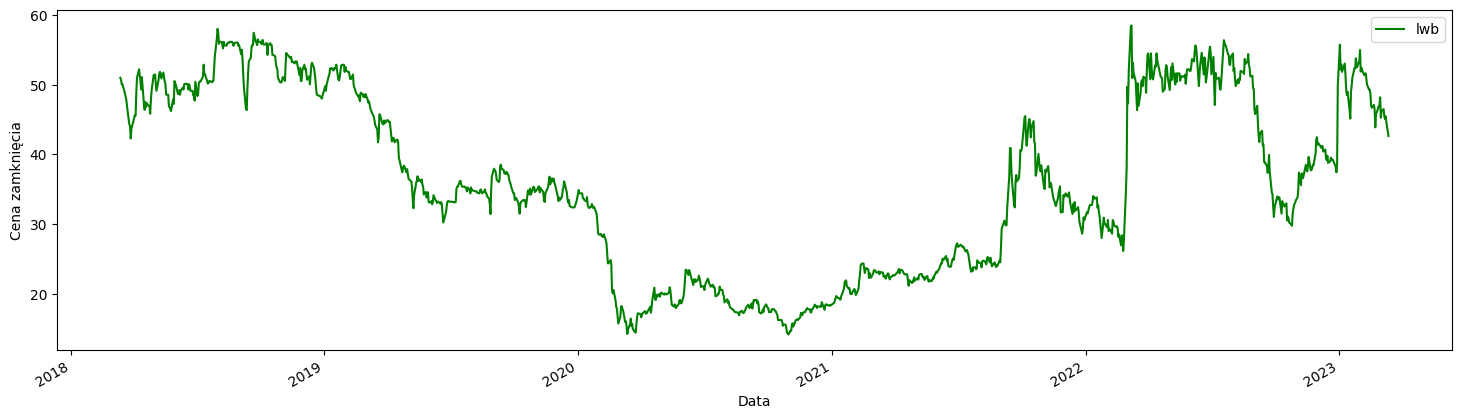

In [ ]:
notowania_wykresy(spolka2, 'green')

### JSW

In [ ]:
spolka3 = notowania_dataframe('jsw', 'Zamkniecie')
spolka3['Data'] = pd.to_datetime(spolka3['Data'], format='%Y-%m-%d')
spolka3

Data     jsw
0    2018-03-13  92.941
1    2018-03-14  90.650
2    2018-03-15  89.742
3    2018-03-16  88.738
4    2018-03-19  87.091
...         ...     ...
1245 2023-03-07  52.600
1246 2023-03-08  53.040
1247 2023-03-09  52.160
1248 2023-03-10  50.660
1249 2023-03-13  48.150

[1250 rows x 2 columns]

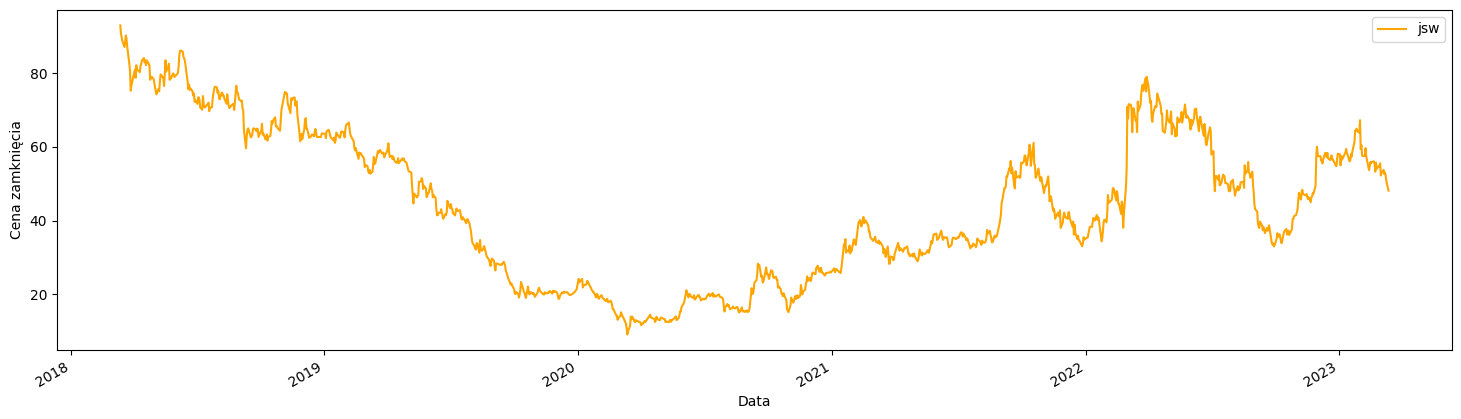

In [ ]:
notowania_wykresy(spolka3, 'orange')

### GAZP

In [ ]:
spolka4 = notowania_dataframe('gazp', 'Ostatnio')
spolka4['Data'] = pd.to_datetime(spolka4['Data'], format='%d.%m.%Y')
spolka4 = spolka4.sort_values('Data', ascending=True)
spolka4['gazp'] = spolka4['gazp'].str.replace(',', '.').astype(float)
spolka4

Data    gazp
1246 2018-03-13  142.75
1245 2018-03-14  138.80
1244 2018-03-15  138.25
1243 2018-03-16  141.00
1242 2018-03-19  139.91
...         ...     ...
4    2023-03-06  163.35
3    2023-03-07  162.57
2    2023-03-09  161.21
1    2023-03-10  160.04
0    2023-03-13  159.03

[1247 rows x 2 columns]

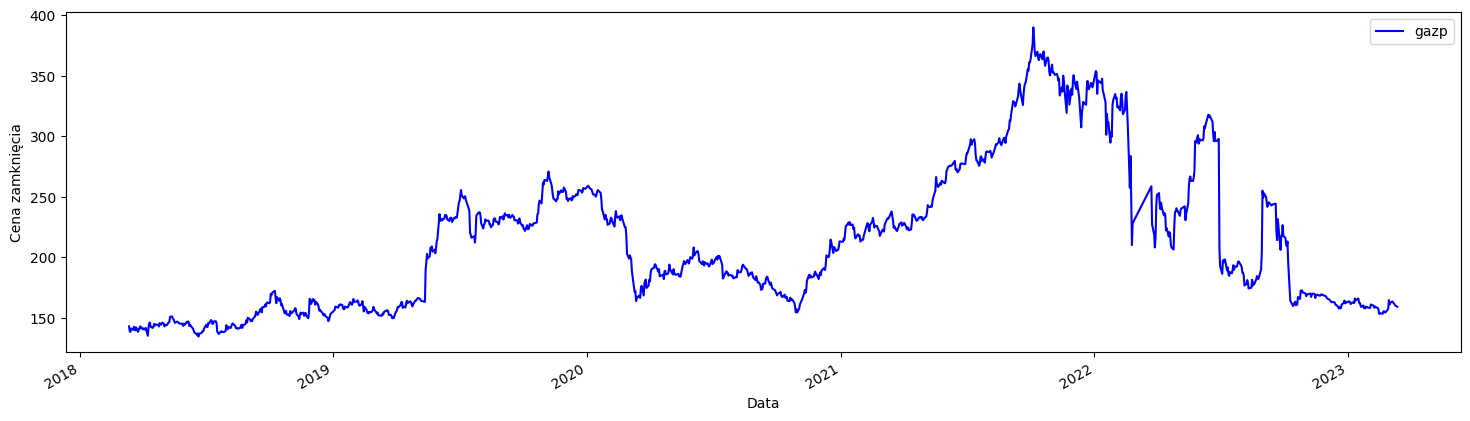

In [ ]:
notowania_wykresy(spolka4, 'blue')

### XOM

In [ ]:
spolka5 = notowania_dataframe('xom', 'Ostatnio')
spolka5['Data'] = pd.to_datetime(spolka5['Data'], format='%d.%m.%Y')
spolka5 = spolka5.sort_values('Data', ascending=True)
spolka5['xom'] = spolka5['xom'].str.replace(',', '.').astype(float)
spolka5

Data     xom
1258 2018-03-13   74.53
1257 2018-03-14   73.60
1256 2018-03-15   74.42
1255 2018-03-16   75.12
1254 2018-03-19   74.15
...         ...     ...
4    2023-03-07  111.61
3    2023-03-08  109.98
2    2023-03-09  109.13
1    2023-03-10  107.78
0    2023-03-13  106.54

[1259 rows x 2 columns]

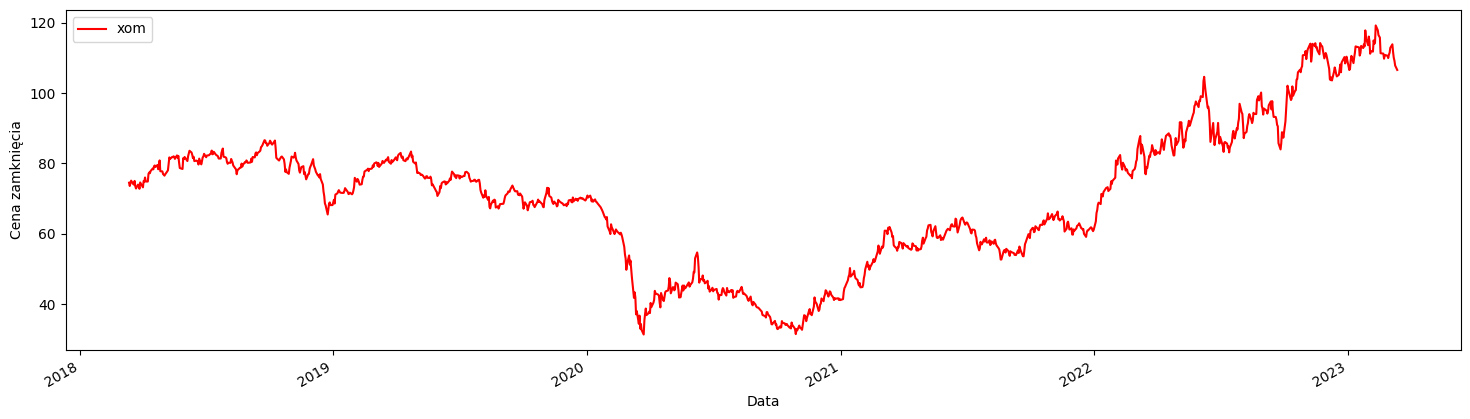

In [ ]:
notowania_wykresy(spolka5, 'red')

### Notowania wszystkich spółek

In [ ]:
#pd.read_csv('/content/wti.csv')

In [ ]:
zmergowane = spolka1.merge(spolka2, on='Data').merge(spolka3, on='Data').merge(spolka4, on='Data').merge(spolka5, on='Data')
zmergowane['Data'] = pd.to_datetime(zmergowane['Data'], format='%Y-%m-%d')
zmergowane = zmergowane.sort_values('Data', ascending=True)
zmergowane

Data       kgh      lwb     jsw    gazp     xom
0    2018-03-13   98.8252  51.0072  92.941  142.75   74.53
1    2018-03-14   99.6408  50.7261  90.650  138.80   73.60
2    2018-03-15   98.9223  50.0712  89.742  138.25   74.42
3    2018-03-16   97.3786  50.0712  88.738  141.00   75.12
4    2018-03-19   91.6136  49.0414  87.091  139.91   74.15
...         ...       ...      ...     ...     ...     ...
1163 2023-03-06  130.0000  46.5000  53.780  163.35  113.81
1164 2023-03-07  125.8500  45.5000  52.600  162.57  111.61
1165 2023-03-09  121.9000  45.4600  52.160  161.21  109.13
1166 2023-03-10  121.4500  44.5600  50.660  160.04  107.78
1167 2023-03-13  119.5500  42.6600  48.150  159.03  106.54

[1168 rows x 6 columns]

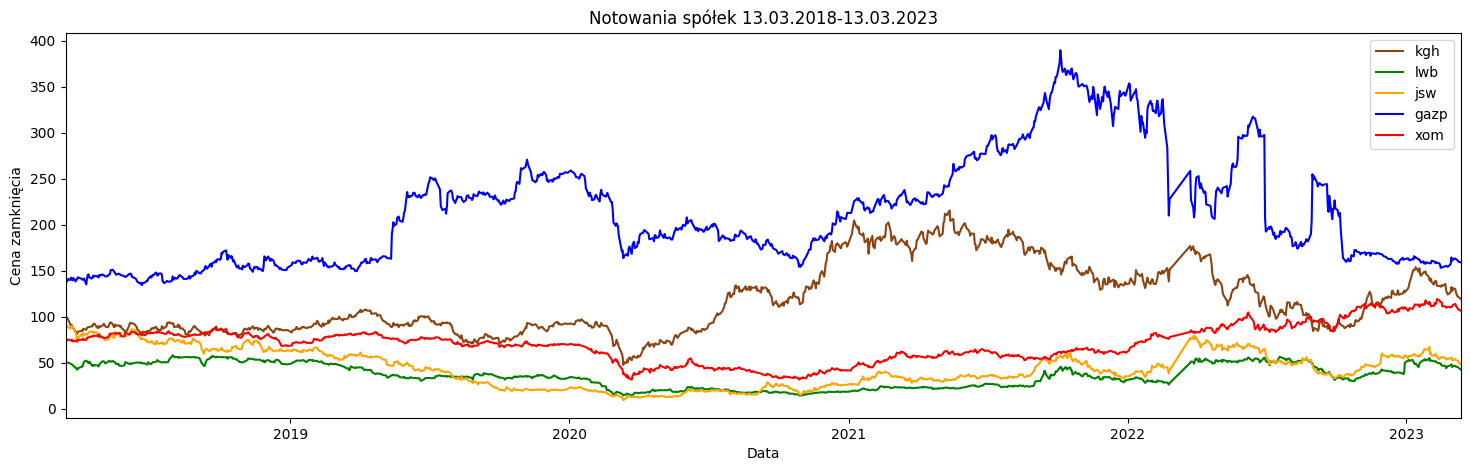

In [ ]:
fig, ax = plt.subplots(figsize=(18, 5))

ax.plot(zmergowane['Data'], zmergowane['kgh'], color="saddlebrown", label="kgh".strip())
ax.plot(zmergowane['Data'], zmergowane['lwb'], color="green", label="lwb".strip())
ax.plot(zmergowane['Data'], zmergowane['jsw'], color="orange", label="jsw".strip())
ax.plot(zmergowane['Data'], zmergowane['gazp'], color="blue", label="gazp".strip())
ax.plot(zmergowane['Data'], zmergowane['xom'], color="red", label="xom".strip())

ax.set_xlim(zmergowane['Data'].min(), zmergowane['Data'].max())

ax.set_title('Notowania spółek 13.03.2018-13.03.2023')
ax.set_xlabel('Data')
ax.set_ylabel('Cena zamknięcia')

ax.legend()

plt.show()


## Przygotowanie i analiza statystyczna danych

### Oczyszczenie danych

Wyświetlając ramki danych naszych spółek, można zauważyć, że liczba wierszy w polskich spółkach jest taka sama, natomiast dane dla spółek zagranicznych zawierają inną liczbę wierszy. Istnieje zatem ryzyko występowania duplikatów lub brakujących wartości. W celu sprawdzenia, czy dane są prawidłowe wyświetlone zostaną również wartości zduplikowane.

In [ ]:
spolki = [spolka1, spolka2, spolka3, spolka4, spolka5]
def oczyszczanie(spolki):
  for spolka in spolki:
    print(f"{spolka.columns[1]}\n")
    duplik = spolka.duplicated(subset=['Data'], keep=False)
    duplikaty = spolka[duplik]
    print(f"\nZduplikowane wartości: \n{duplikaty}\n")


In [ ]:
oczyszczanie(spolki)

kgh


Zduplikowane wartości: 
Empty DataFrame
Columns: [Data, kgh]
Index: []

lwb


Zduplikowane wartości: 
Empty DataFrame
Columns: [Data, lwb]
Index: []

jsw


Zduplikowane wartości: 
Empty DataFrame
Columns: [Data, jsw]
Index: []

gazp


Zduplikowane wartości: 
Empty DataFrame
Columns: [Data, gazp]
Index: []

xom


Zduplikowane wartości: 
Empty DataFrame
Columns: [Data, xom]
Index: []



Dane, pomimo zróżnicowanej liczby wierszy w kolumnach, nie zawierają błędów w postaci zduplikowanych wartości. Poniżej wyświetlone zostaną daty, dla których przynajmniej jedna ze spółek nie posiada notowań.

In [ ]:
spolki = pd.merge(spolka1, spolka2, on="Data", how="outer")
spolki = pd.merge(spolki, spolka3, on="Data", how="outer")
spolki = pd.merge(spolki, spolka4, on="Data", how="outer")
spolki = pd.merge(spolki, spolka5, on="Data", how="outer")

brakujaca_data = spolki[spolki.iloc[:, 1:].isnull().any(axis=1)]
brakujaca_data

Data      kgh      lwb     jsw    gazp    xom
37   2018-05-09  90.0155  51.8496  77.738     NaN  79.93
50   2018-05-28  86.0689  47.9189  79.934  145.09    NaN
60   2018-06-12  90.0350  49.3225  84.327     NaN  82.42
76   2018-07-04  86.2029  50.1649  73.459  142.24    NaN
118  2018-09-03  89.2456  54.3767  72.418  148.73    NaN
...         ...      ...      ...     ...     ...    ...
1301 2020-05-01      NaN      NaN     NaN     NaN  43.14
1302 2020-12-31      NaN      NaN     NaN     NaN  41.22
1303 2021-05-03      NaN      NaN     NaN     NaN  58.82
1304 2021-12-31      NaN      NaN     NaN     NaN  61.19
1305 2022-05-03      NaN      NaN     NaN     NaN  88.19

[138 rows x 6 columns]

Dane giełdowe dla różnych rynków i krajów nie są do końca spójne. W wyniku różnic kulturowych święta narodowe oraz lokalne przypadają w różne dni, a notowania w tych dniach nie są publikowane.

Istnieje kilka technik uzupełniania brakujących danych. Można zdecydować się na pominięcie dat, dla których dane występują jedynie w niektórych spółkach. W takim przypadku istnieje jednak ryzyko, że wyniki mogą być mniej dokładne, ponieważ będą uwzględniały tylko niektóre dane (około 90%).

Z tego względu zdecydowaliśmy się na uzupełnienie pustych miejsc za pomocą interpolacji liniowej.


#### Eliminacja wartości odstających 

Aby pozyskać wiarygodne rezultaty użycia metod uczenia maszynowego (tj. niezaburzone, niezniekształcone wyniki), podobnie jak w przypadku standardowych badań statystycznych niezbędne jest nie tylko uzupełnienie braków, ale również zbadanie zbioru pod kątem obecności wartości nietypowych, tzw *outlierów*. Pod pojęciem tym należy rozumieć wartości zdolne do zaburzenia założeń stawianych przed potencjalnymi modelami. Usunięcie ów wartości jest jednak uzasadnione w określonych przypadkach. Metody wykrywania obserwacji odstających (reguła trzech sigm, reguła 1.5-krotności wartoci rozstępu międzykwartylowego etc) zależne są od przyjmowanego rozkładu. W przypadku rozkładu normalnego, zgodnie z regułą trzech sigm uznaje się, że wartości odstające to te przekraczające wartość trzykrotnej wartości odchyleń standardowych od wartości oczekiwanej. Naszym zdaniem z pewną dozą prawdopodobieństwa mamy tu do czynienia z naturalną skłonnością do generowania wartości odstających i stanowi to naturalny element dystrybucji informacji - idealne dopasowanie nie musi nieść za sobą poprawy prognozowania, stąd zrezygnowano z eliminacji wspomnianych wartości.

### Interpolacja

Dokonana zostanie interpolacja liniowa, która na podstawie znanych wartości znajduje funkcję liniową łączącą dwie najbliższe wartości. Na tej podstawie oblicza brakujące wartości.

W przypadku brakujących wartości, do których nie można dokonać interpolacji (np. jeśli brakuje wartości na początku lub na końcu ramki danych), algorytm będzie próbował uzupełnić te braki z obu stron - zarówno przed pierwszą wartością, jak i za ostatnią.

In [ ]:

# rząd opóźnień, testy do zmian strukturalnych
#rezygnacja z korelacji Pearsona, Rang Spearmana, macierzy korelacji bo rozpatrujemy po 1 zmiennej

In [ ]:
spolki['Data'] = pd.to_datetime(spolki['Data'], format='%Y-%m-%d')
spolki = spolki.sort_values('Data', ascending=True)
spolki.set_index('Data', inplace=True)
spolki

kgh      lwb     jsw    gazp     xom
Data                                                 
2018-03-13   98.8252  51.0072  92.941  142.75   74.53
2018-03-14   99.6408  50.7261  90.650  138.80   73.60
2018-03-15   98.9223  50.0712  89.742  138.25   74.42
2018-03-16   97.3786  50.0712  88.738  141.00   75.12
2018-03-19   91.6136  49.0414  87.091  139.91   74.15
...              ...      ...     ...     ...     ...
2023-03-07  125.8500  45.5000  52.600  162.57  111.61
2023-03-08  126.0000  45.0800  53.040     NaN  109.98
2023-03-09  121.9000  45.4600  52.160  161.21  109.13
2023-03-10  121.4500  44.5600  50.660  160.04  107.78
2023-03-13  119.5500  42.6600  48.150  159.03  106.54

[1306 rows x 5 columns]

In [ ]:
spolki_interpolacja = spolki.interpolate(method='linear', limit_direction='both')

In [ ]:
spolki_interpolacja

kgh      lwb     jsw    gazp     xom
Data                                                 
2018-03-13   98.8252  51.0072  92.941  142.75   74.53
2018-03-14   99.6408  50.7261  90.650  138.80   73.60
2018-03-15   98.9223  50.0712  89.742  138.25   74.42
2018-03-16   97.3786  50.0712  88.738  141.00   75.12
2018-03-19   91.6136  49.0414  87.091  139.91   74.15
...              ...      ...     ...     ...     ...
2023-03-07  125.8500  45.5000  52.600  162.57  111.61
2023-03-08  126.0000  45.0800  53.040  161.89  109.98
2023-03-09  121.9000  45.4600  52.160  161.21  109.13
2023-03-10  121.4500  44.5600  50.660  160.04  107.78
2023-03-13  119.5500  42.6600  48.150  159.03  106.54

[1306 rows x 5 columns]

Podział ze względu na notowania w dni robocze

In [ ]:
# spolki_interpolacja['Dzień tygodnia'] = spolki_interpolacja.index.weekday
# dni_robocze = spolki_interpolacja.groupby(spolki_interpolacja['Dzień tygodnia'] < 5).get_group(True)
# weekendy = spolki_interpolacja.groupby(spolki_interpolacja['Dzień tygodnia'] > 4).get_group(True)

In [ ]:
# print(dni_robocze)

In [ ]:
# print(weekendy)

<function matplotlib.pyplot.show(close=None, block=None)>

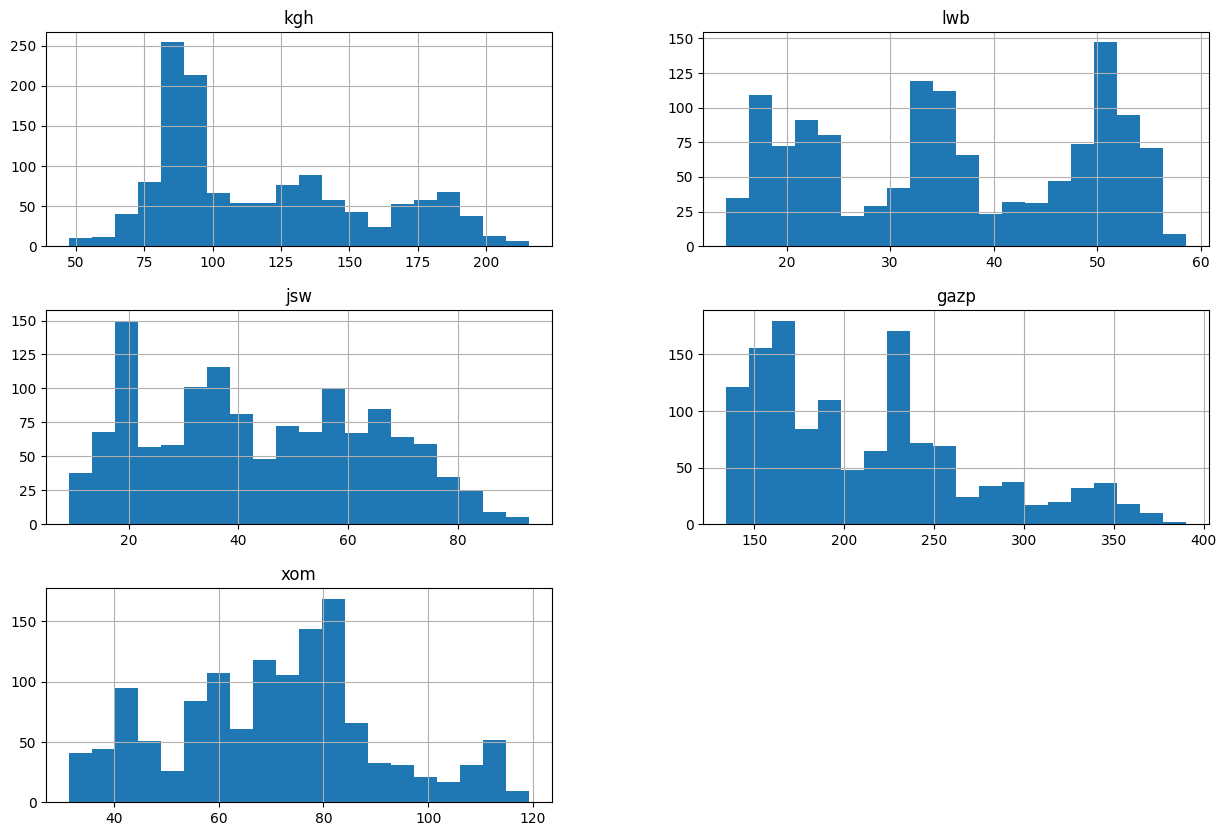

In [ ]:
spolki_interpolacja.hist(bins=20, figsize=(15,10))
plt.show

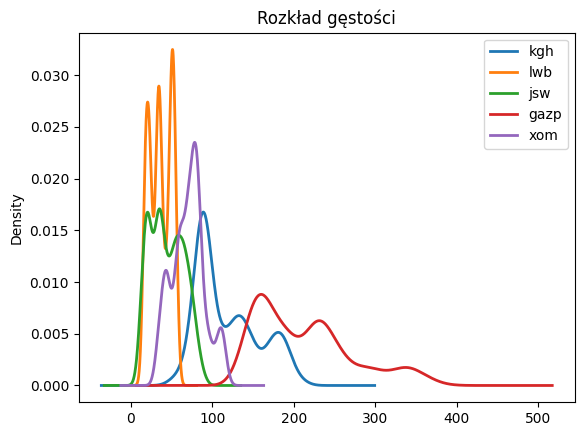

In [ ]:
spolki_interpolacja.plot(kind='density', linewidth=2, title='Rozkład gęstości')
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


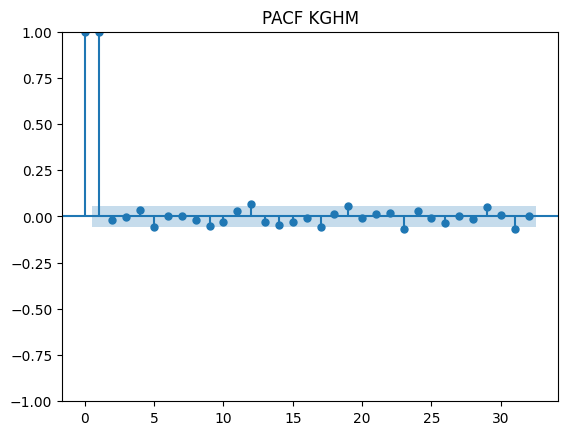

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(spolki_interpolacja['kgh'])
plt.title('PACF KGHM')
plt.show()

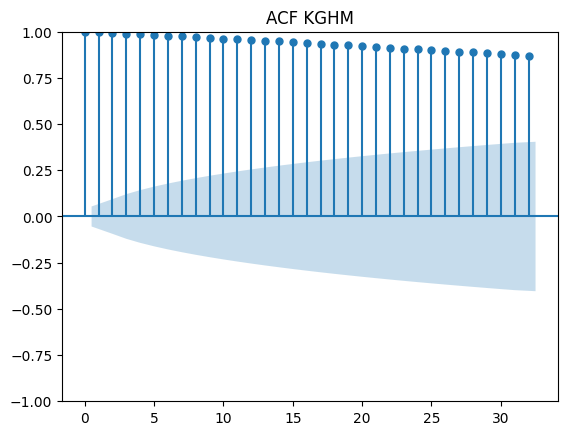

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(spolki_interpolacja['kgh'])
plt.title('ACF KGHM')
plt.show()

### Analiza statystyczna

W poniższym etapie analizowane szeregi czasowe zostaną poddane elementarnej analizie statystycznej. Za sprawą kilku testów zweryfikowana zostanie między innymi hipoteza dotycząca rozkładu normalnego jako rozkładu najlepiej definiującego szeregi cen zamknięcia spółek.

Na początku warto przyjrzeć się wartościom miar opisujących strukturę zbiorowości - oprócz miar położenia, czyli m.in. miar tendencji centralnej (m.in. średnia/mediana) i kwantyli kluczowe znaczenie mogą mieć dla nas wartości kurtozy i skośności.

In [ ]:
statystyki = spolki_interpolacja.describe()

statystyki.loc['var']=spolki_interpolacja.var().to_list()
statystyki.loc['std']=spolki_interpolacja.std().to_list()
statystyki.loc['kurt']=spolki_interpolacja.kurtosis().to_list()
statystyki.loc['skośność']=spolki_interpolacja.skew().to_list()
#statystyki.loc['moda']=np.bincount(spolki_interpolacja).argmax().to_list()

statystyki

kgh          lwb          jsw         gazp          xom
count     1306.000000  1306.000000  1306.000000  1306.000000  1306.000000
mean       118.094075    36.174914    44.260208   213.052691    70.755456
std         38.255241    12.864034    20.184757    59.148614    19.875349
min         47.559200    14.170000     9.130000   134.400000    31.450000
25%         87.940750    23.425413    26.332500   162.396250    57.087500
50%        103.005000    34.994700    41.836500   198.835000    71.910000
75%        144.911750    49.429375    61.854000   244.850000    81.880000
max        215.456000    58.515800    92.941000   389.820000   119.170000
var       1463.463482   165.483368   407.424421  3498.558490   395.029482
kurt        -0.769329    -1.364759    -1.077252    -0.114454    -0.390281
skośność     0.651690    -0.016751     0.189147     0.829896     0.146938

In [ ]:
print(mode(spolki_interpolacja))

ModeResult(mode=array([[ 90.0155,  34.4211,  20.56  , 141.5   ,  60.93  ]]), count=array([[ 6, 12,  5,  4,  3]]))


<ipython-input-45-497350319048>:1: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  print(mode(spolki_interpolacja))


Z powyższej tabeli wyciągamy standardowy wniosek - żaden szereg nie ma rozkładu symetrycznego, ujemne wartości współczynnika kurtozy to zaś odrzucenie hipotezy o rozkładzie normalnym (wyraźne spłaszczenie, platokurtoza). Na temat asymetrii każdego szereg więcej może nam powiedzieć bieżący stosunek średniej, mediany i dominanty:

*   Dla spółek polskich i rosyjskiej mamy do czynienia z rozkładem prawoskośnym (średnia > mediana > moda),
*   ExxonMobil cechuje się z dużym prawdopodobieństwem rozkładem lewoskośnym (mediana > średnia > dominanta, typowy rozkład ma jednak stosunek dominanta > mediana > średnia).

Wnioski te nie do końca potwierdza wartość współczynnika skośności - dodatnia wartość sugeruje prawostronny charakter rozkładu i z takim mamy do czynienia z dużym prawdopodobieństwem w przypadku spółek **KGHM** i **Gazprom** (skośność silna/b.silna). Pozostałe, szczególnie **Bogdanka** zbliżone są do rozkładu symetrycznego (zbliżona wartość miar tendencji centralnej). Ciekawy przypadek to rozkład cen zamknięcia ExxonMobil - wartość wsp. skośności jest dodatnia (skośność bardzo słaba), stosunek miar tendencji centralnej jest wobec tego niejednoznaczny.


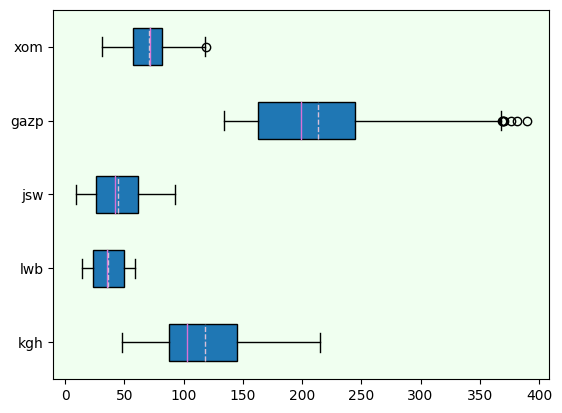

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

fig, ax = plt.subplots()
ax.boxplot((spolki_interpolacja['kgh'], spolki_interpolacja['lwb'], spolki_interpolacja['jsw'], spolki_interpolacja['gazp'], spolki_interpolacja['xom']),
           vert=False, showmeans=True, showfliers=True, meanline=True,
           labels=('kgh', 'lwb', 'jsw', 'gazp', 'xom'), patch_artist=True,
           medianprops={'linewidth': 1, 'color': 'orchid'},
           meanprops={'linewidth': 1, 'color': 'thistle'})
ax.set_facecolor("honeydew")
plt.show()

#gazprom i exxon posiadają outliery (kółka)

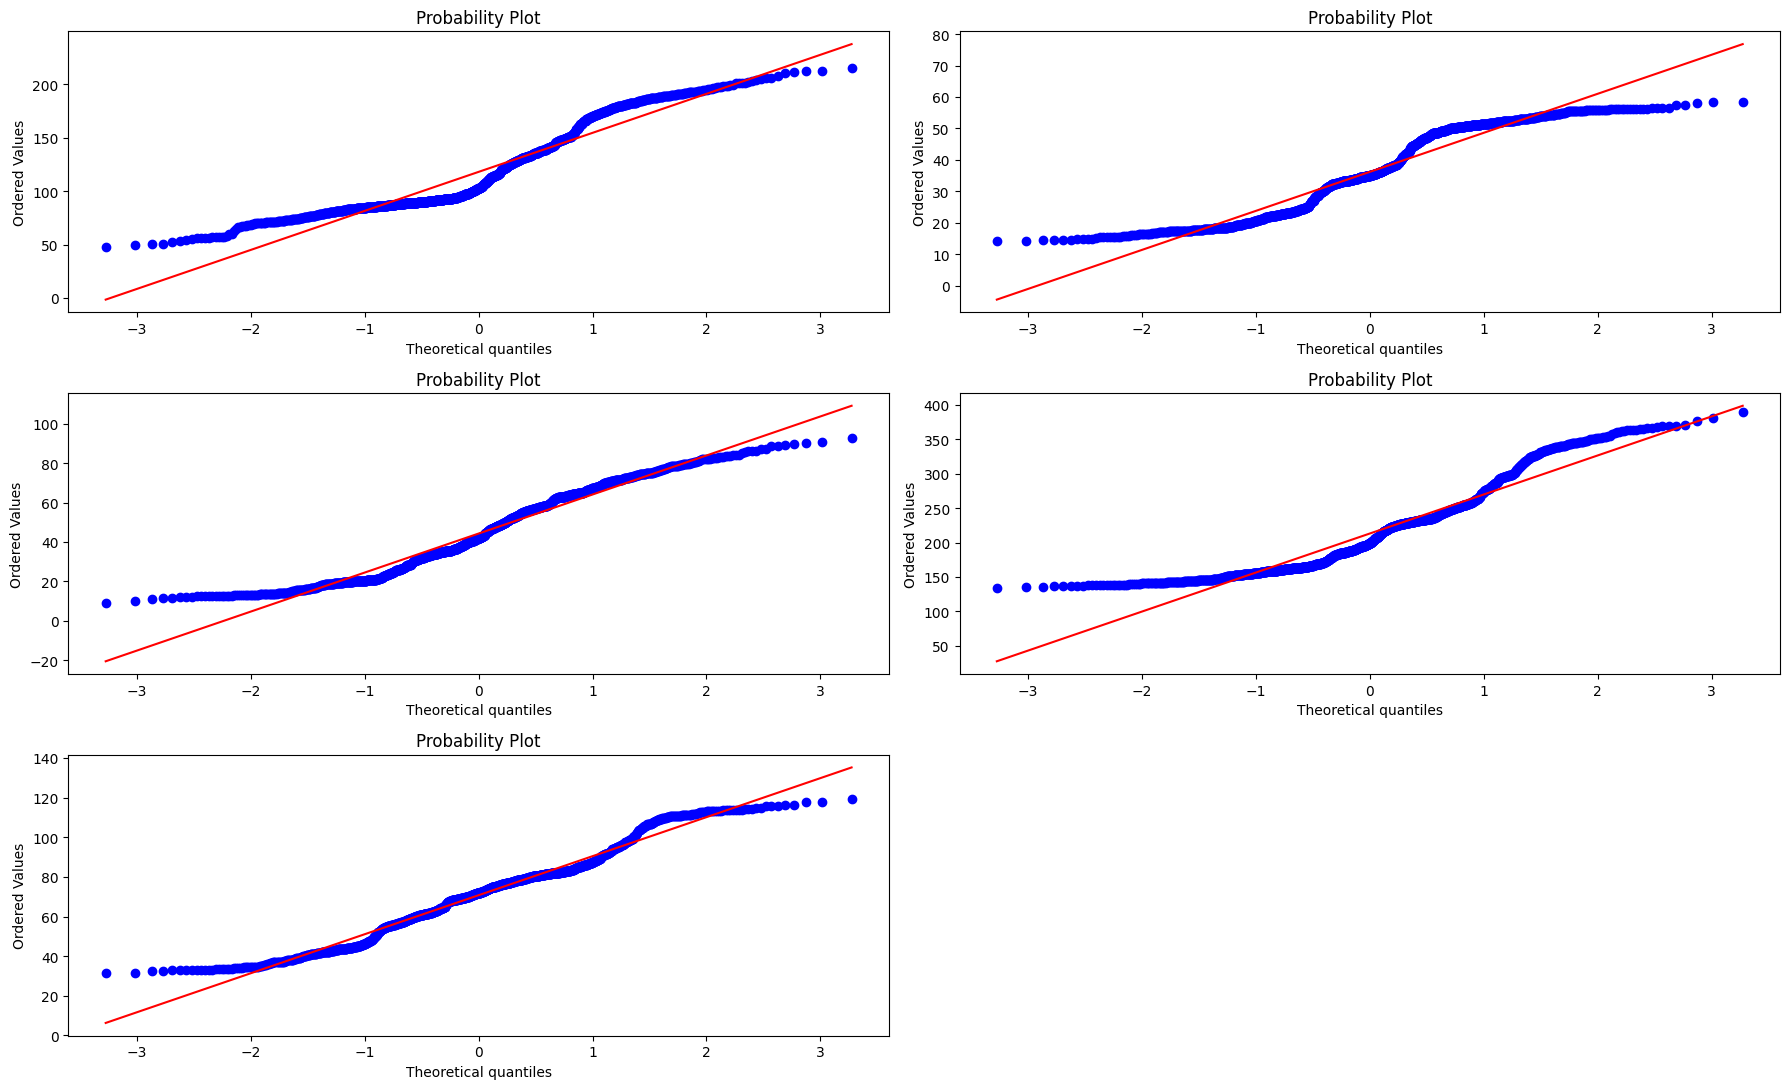

In [ ]:
#acf=sns.FacetGrid(spolki_interpolacja)
#pplot(spolki_interpolacja['kgh'], kind='qq')

fig=plt.figure(1, (18,11))

ax=plt.subplot (3, 2, 1)
stats.probplot(spolki_interpolacja['kgh'], plot=plt) #zgadza się to z histogramem

ax=plt.subplot (3, 2, 2)
stats.probplot(spolki_interpolacja['lwb'], plot=plt)

ax=plt.subplot (3, 2, 3)
stats.probplot(spolki_interpolacja['jsw'], plot=plt) 

ax=plt.subplot (3, 2, 4)
stats.probplot(spolki_interpolacja['gazp'], plot=plt) 

ax=plt.subplot (3, 2, 5)
stats.probplot(spolki_interpolacja['xom'], plot=plt) 
plt.tight_layout()
plt.show()

#qqplot(spolki_interpolacja['kgh'], line='s')

Na kolejne przemyślenia pozwalają wykresy pudełkowe i wykresy QQ. Pierwsze z wymienionych pozwalają uzupełnić wnioski dotyczące rozproszenia - szerokość pudełka wyznaczają wartości kwartyli Q3 i Q1. Niesymetryczne położenie mediany (fioletowy pasek), wyraźnie różna długość tzw. wąsów świadczą o wysokim zróżnicowaniu i prawostronnej asymetrii (wszystkie poza **Bogdanką**, zwłaszcza *Gazprom*; prawy wąs dłuższy od lewego, wątpliwość tylko dla Exxon). Zagraniczne spółki dodatkowo posiadają wartości odstające (oznaczone symbolem kółka). Bogdanka posiada wyraźnie mniejszą dyspersję (stosunek wielkości pudełka i długości wąsów).

Wykresy kwantylowe potwierdzają rozbieżność z rozkładem normalnym, zwłaszcza na krańcach rozkładów.

In [ ]:

# def QQplots(self, spolka):
#   fig=plt.figure(1, (18,11))
#   ax=plt.subplot (3, 3, 1)
#   stats.probplot(spolki_interpolacja[f'{spolka}'], plot=plt) 
#   ax=plt.subplot (3, 3, 2)
#   stats.probplot(spolki_interpolacja[f'{spolka}'], dist=stats.skewnorm, plot=plt)
#   ax=plt.subplot (3, 3, 3)
#   stats.probplot(spolki_interpolacja[f'{spolka}'], dist=stats.lognorm, plot=plt) 
#   ax=plt.subplot (3, 3, 4)
#   stats.probplot(spolki_interpolacja[f'{spolka}'],dist='skewnorm', plot=plt) 
#   ax=plt.subplot (3, 3, 5)
#   stats.probplot(spolki_interpolacja[f'{spolka}'],dist='bernoulli', plot=plt)
#   ax=plt.subplot (3, 3, 6)
#   stats.probplot(spolki_interpolacja[f'{spolka}'],dist='poisson', plot=plt) 
#   ax=plt.subplot (3, 3, 7)
#   stats.probplot(spolki_interpolacja[f'{spolka}'],dist='t', plot=plt)  
#   ax=plt.subplot (3, 3, 8)
#   stats.probplot(spolki_interpolacja[f'{spolka}'],dist='geom', plot=plt)
#   ax=plt.subplot (3, 3, 9)
#   stats.probplot(spolki_interpolacja[f'{spolka}'],dist='expon', plot=plt)    
#   plt.tight_layout()
#   plt.show()

In [ ]:
# stats.probplot(spolki_interpolacja['kgh'], dist=stats.lognorm(math.log(spolki_interpolacja['kgh'].std())), plot=plt)

In [ ]:

def testy(spolka):
  print(f'Wartości testów przeprowadzono dla spółki giełdowej z symbolem {spolka} \n')
  jb=jarque_bera(spolki_interpolacja[f'{spolka}'])
  print('Jarque-Bera Statistic: %f' % jb[0])
  print('p-value: %f' % jb[1])
  print('----------------------------')
  shapiro1=shapiro(spolki_interpolacja[f'{spolka}'])
  print('Shapiro Statistic: %f' % shapiro1[0])
  print('p-value: %f' % shapiro1[1])
  print('----------------------------')
  kt=kurtosistest(spolki_interpolacja[f'{spolka}'], alternative = 'two-sided')
  print('KurtosisTest, Statistic: %f' % kt[0])
  print('p-value: %f' % kt[1])
  print('----------------------------')
  tt=ttest_1samp(spolki_interpolacja[f'{spolka}'], 0, alternative = 'two-sided')
  print('ttest, Statistic: %f' % tt[0])
  print('p-value: %f' % tt[1])
  print('----------------------------')
  adf=adfuller(spolki_interpolacja[f'{spolka}'])
  print('ADF Statistic: %f' % adf[0])
  print('p-value: %f' % adf[1])
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n')

In [ ]:
#QQplots('kgh')

In [ ]:
#testy
for i in enumerate(spolki_interpolacja.columns):
  testy(spolki_interpolacja.columns[i[0]])


Wartości testów przeprowadzono dla spółki giełdowej z symbolem kgh 

Jarque-Bera Statistic: 124.576356
p-value: 0.000000
----------------------------
Shapiro Statistic: 0.909347
p-value: 0.000000
----------------------------
KurtosisTest, Statistic: -9.666644
p-value: 0.000000
----------------------------
ttest, Statistic: 111.560063
p-value: 0.000000
----------------------------
ADF Statistic: -1.546503
p-value: 0.510395
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Wartości testów przeprowadzono dla spółki giełdowej z symbolem lwb 

Jarque-Bera Statistic: 101.322292
p-value: 0.000000
----------------------------
Shapiro Statistic: 0.926412
p-value: 0.000000
----------------------------
KurtosisTest, Statistic: 218.731044
p-value: 0.000000
----------------------------
ttest, Statistic: 101.625319
p-value: 0.000000
----------------------------
ADF Statistic: -1.639144
p-value: 0.462708
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Wartości testów przeprowadzono dla spółki giełdowej z symbo

Konkluzje z rezultatów testów powyżej nie są jednakowe dla każdej spółki, dlatego też objaśniamy poniżej wnioski z potencjalnego odrzucenia h0 w danym teście: 

*   Test Jarque-Bera: odrzucenie hipotezy o rozkładzie normalnym dla odchyleń losowych; w większości bardzo wysoka wartość statystyki testowej,
*   Rozszerzony test Dickeya-Fullera: szeregi cen są stacjonarne (często różnicowanie jest niezbędne dla uzyskania stacjonarności);  Brak obecności pierwiastka jednostkowego potwierdza, że szeregi opóźnione nie przyniosą dodatkowych informacji przydatnych w przewidywaniu zmiany cen zamknięcia.
*   Kurtoza, test Shapiro-Wilka: rozkład definiujący próbę nie ma charakteru rozkładu normalnego,
*   test T-studenta dla 1 próby: wartość oczekiwana (średnia teoretyczna) z próby nie jest równa jej średniej, nie mamy do czynienia z rozkładem t-Studenta (powiązane z badaniem rozkładu normalnego).

Wnioski na podstawie wartości statystyk testowych:

1.   KGHM, JSW, Bogdanka, ExxonMobil - szereg niestacjonarny o rozkładzie innym niż normalny i t-Studenta,
2.   Gazprom - szereg niestacjonarny, brak podstaw do odrzucenia hipotezy zerowej mówiącej o kurtozie próby scharakteryzowanej rozkładem normalnym (wartość kurtozy wyniosła najmniej, bo -0,11).

Fakt nieodrzucenia hipotezy zerowej mówiącej o obecności pierwiastka jednostkowego (niestacjonarność)
nie jest zaskoczeniem, skoro mamy bowiem do czynienia z ciągłą zmianą wartości zamiast ciągłego powracania do średniej (fakt empiryczny).


### Wykresy autokorelacji, histogram i funkcja gęstości

Poniżej dalsza część analizy potwierdzająca wcześniejsze wnioski - 
Rozkłady wielomodalne, najbliżej rozkładu lewoskośnego rozkład szeregu cen zamknięcia ExxonMobil. Podręcznikowa niestacjonarność, sugestia pierwszego,drugiego rzędu opóźnień w modelu autoregresji (PACF), istotna statystycznie pozytywna autokorelacja nawet dla 50. rzędu opóźnień, wyraźna zależność od wartości przeszłych (jednakowa korelacja wszystkich opóźnień z danymi).

**Jedyna istotna korelacja występuje dla opóźnienia jednostkowego!**

(wykresy ACF, PACF - obszarem zacienionym przedział ufności)

### KGH


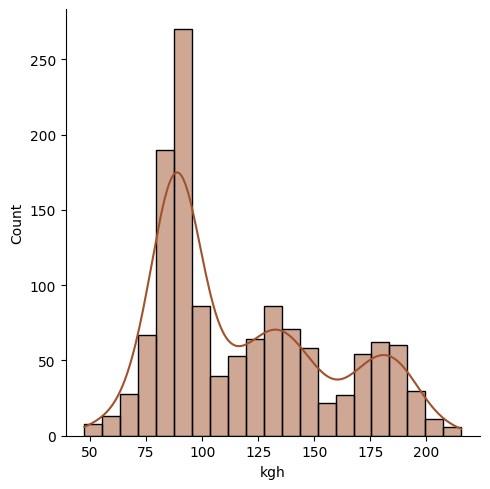

In [ ]:
sns.displot(spolki_interpolacja['kgh'], kde=True, bins=21, color="sienna")

#lub histplot

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


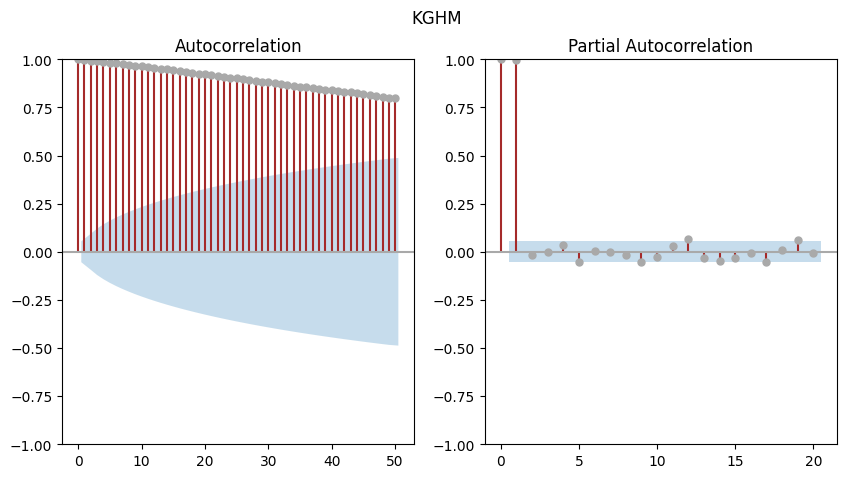

In [ ]:
fig, ax=plt.subplots(1,2, figsize=(10,5))

plot_acf(spolki_interpolacja['kgh'], lags=50, color="darkgrey", vlines_kwargs={"colors": "brown"}, ax=ax[0])
plot_pacf(spolki_interpolacja['kgh'], lags=20, color="darkgrey", vlines_kwargs={"colors": "brown"}, ax=ax[1])
fig.suptitle('KGHM')
plt.show()

### Bogdanka


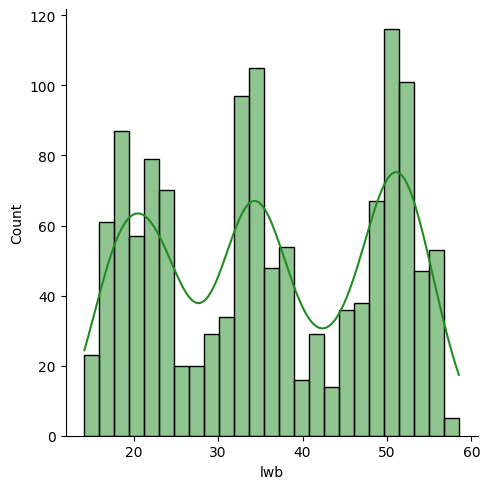

In [ ]:
sns.displot(spolki_interpolacja['lwb'], kde=True, bins=25, color="forestgreen")

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


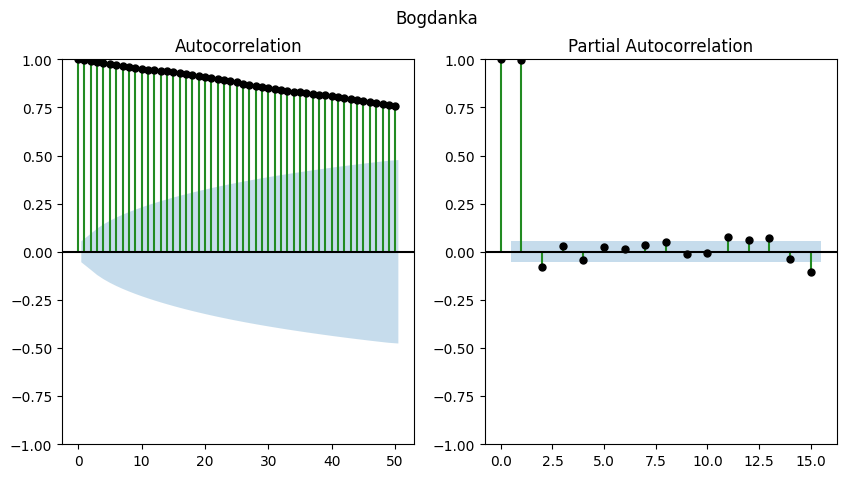

In [ ]:

fig, ax=plt.subplots(1,2, figsize=(10,5))

plot_acf(spolki_interpolacja['lwb'], lags=50, color="black", vlines_kwargs={"colors": "forestgreen"}, ax=ax[0])
plot_pacf(spolki_interpolacja['lwb'], lags=15, color="black", vlines_kwargs={"colors": "forestgreen"}, ax=ax[1])
fig.suptitle('Bogdanka')
plt.show()

### JSW


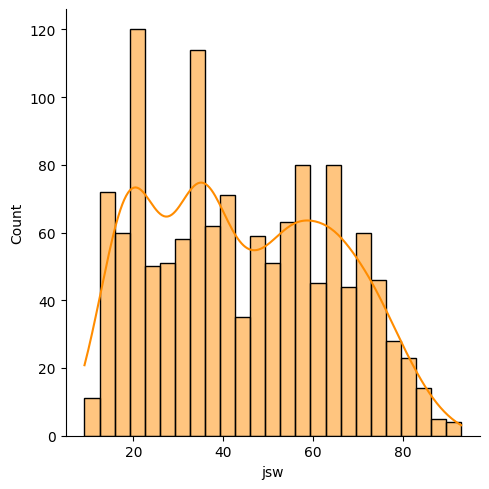

In [ ]:
sns.displot(spolki_interpolacja['jsw'], kde=True, bins=25, color="darkorange")

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


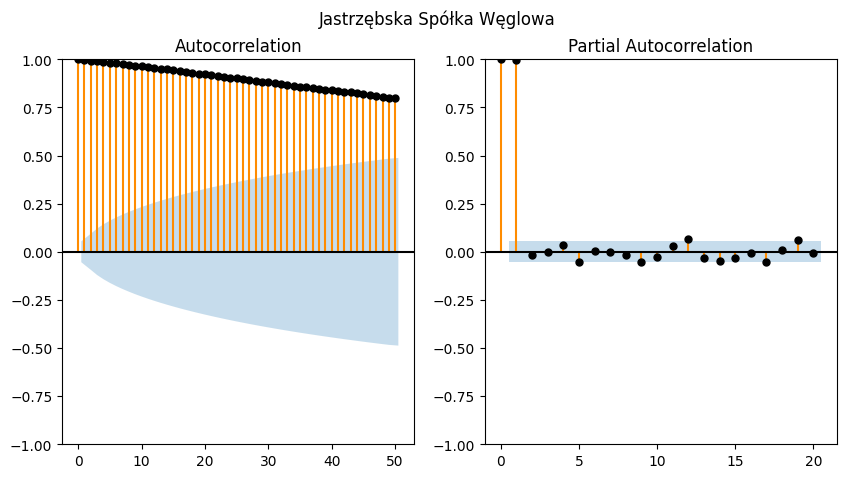

In [ ]:
fig, ax=plt.subplots(1,2, figsize=(10,5))

plot_acf(spolki_interpolacja['kgh'], lags=50, color="black", vlines_kwargs={"colors": "darkorange"}, ax=ax[0])
plot_pacf(spolki_interpolacja['kgh'], lags=20, color="black", vlines_kwargs={"colors": "darkorange"}, ax=ax[1])
fig.suptitle('Jastrzębska Spółka Węglowa')
plt.show()

### Gazprom

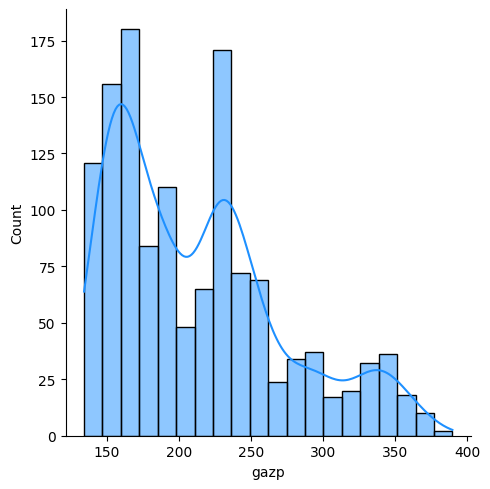

In [ ]:
sns.displot(spolki_interpolacja['gazp'], kde=True, bins=20, color="dodgerblue")

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


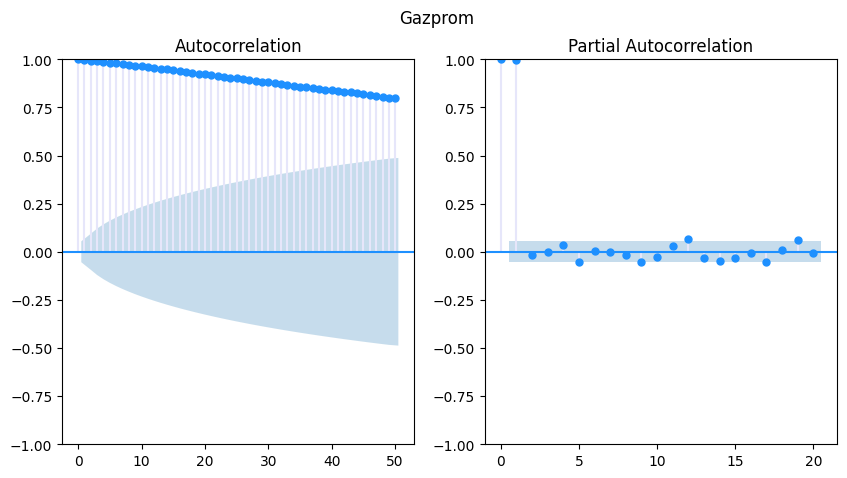

In [ ]:
fig, ax=plt.subplots(1,2, figsize=(10,5))

plot_acf(spolki_interpolacja['kgh'], lags=50, color="dodgerblue", vlines_kwargs={"colors": "lavender"}, ax=ax[0])
plot_pacf(spolki_interpolacja['kgh'], lags=20, color="dodgerblue", vlines_kwargs={"colors": "lavender"}, ax=ax[1])
fig.suptitle('Gazprom')
plt.show()

### exxon

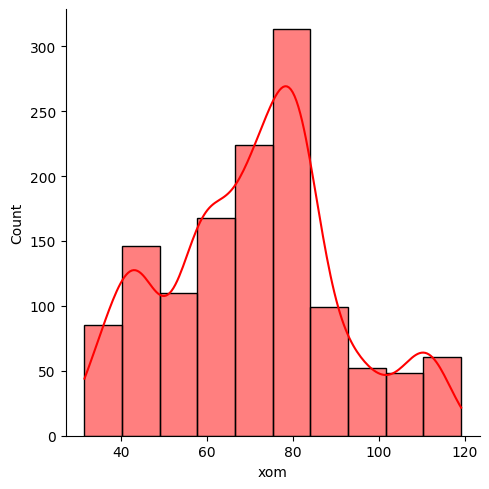

In [ ]:
sns.displot(spolki_interpolacja['xom'], kde=True, bins=10, color="red")

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


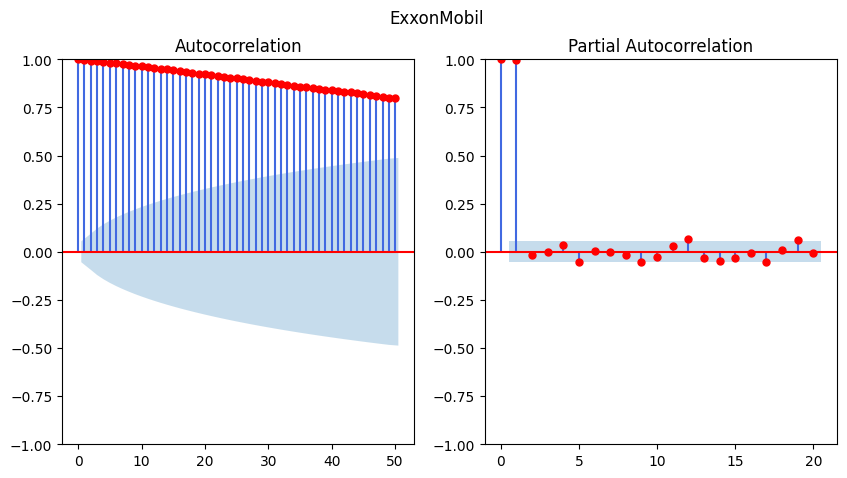

In [ ]:
fig, ax=plt.subplots(1,2, figsize=(10,5))

plot_acf(spolki_interpolacja['kgh'], lags=50, color="red", vlines_kwargs={"colors": "royalblue"}, ax=ax[0])
plot_pacf(spolki_interpolacja['kgh'], lags=20, color="red", vlines_kwargs={"colors": "royalblue"}, ax=ax[1])
fig.suptitle('ExxonMobil')
plt.show()

### Całościowy raport

Na zakończenie, jako podsumowanie wyciągniętych wniosków, wykorzystanie interesującego modułu oferującego *EDA (Exploratory Data Analysis)*. Wyciągamy z niego między innymi dodatkowe wnioski o korelacji między kilkoma szeregami.

In [ ]:
raport = ProfileReport(spolki_interpolacja)
display(raport)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Wstępne modelowanie

 Przewodnim celem naszego projektu jest stworzenie modelu uczenia maszynowego opartego na subiektywnie wybranych zmiennych. Oceny jakości dopasowania/zdolności prognostycznej modelu można dokonać na podstawie błędów prognozy. Uzyskana w ten sposób wartość niesie za sobą pewną informację, jednak znacznie więcej powie nam również jej porównanie z wartością błędów prognozy uzyskiwanych przez mniej skomplikowane modele. Na potrzeby niniejszego projektu będzie nim model SVR.

 We wstępnym modelowaniu w pierwszej kolejności podzielono zbiór na treningowy i testowy za pomocą wbudowanej funkcji train_test_split. Przyjęto, że liczebność próbek w zbiorze treningowym stanowić będzie 80% liczebności próby, natomiast testowy - 20%. Dane zostały podzielone w taki sposób, aby zachować chronologię cen akcji, która jest w tym przypadku istotna.

In [ ]:
spolki_interpolacja['Data']=spolki_interpolacja.index
#spolki_interpolacja

X=spolki_interpolacja.drop(['kgh', 'lwb', 'jsw', 'gazp', 'xom'], axis=1).to_numpy()
Y_kgh=spolki_interpolacja['kgh'].to_numpy()
Y_lwb=spolki_interpolacja['lwb'].to_numpy()
Y_jsw=spolki_interpolacja['jsw'].to_numpy()
Y_gazp=spolki_interpolacja['gazp'].to_numpy()
Y_xom=spolki_interpolacja['xom'].to_numpy()


In [ ]:

#podział na próbki uczące i testowe
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X, Y_kgh, test_size=0.2, shuffle = False)
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X, Y_lwb, test_size=0.2, shuffle = False)
X3_train, X3_test, Y3_train, Y3_test = train_test_split(X, Y_jsw, test_size=0.2, shuffle = False)
X4_train, X4_test, Y4_train, Y4_test = train_test_split(X, Y_gazp, test_size=0.2, shuffle = False)
X5_train, X5_test, Y5_train, Y5_test = train_test_split(X, Y_xom, test_size=0.2, shuffle = False)


In [ ]:
X1_train[:5]  

array([['2018-03-13T00:00:00.000000000'],
       ['2018-03-14T00:00:00.000000000'],
       ['2018-03-15T00:00:00.000000000'],
       ['2018-03-16T00:00:00.000000000'],
       ['2018-03-19T00:00:00.000000000']], dtype='datetime64[ns]')

In [ ]:
X1_test[:5]

array([['2022-03-11T00:00:00.000000000'],
       ['2022-03-14T00:00:00.000000000'],
       ['2022-03-15T00:00:00.000000000'],
       ['2022-03-16T00:00:00.000000000'],
       ['2022-03-17T00:00:00.000000000']], dtype='datetime64[ns]')

Następnie zdefiniowano siatkę dwóch hiperparametrów, które będą poddawane optymalizacji w procesie GridSearch. Hiperparametry C i epsilon mogą przyjmować wartości od 0.01 do 10.0.

Wybrano model Supper Vector Regression z jądrem radialnej funkcji bazowej.

Przestestowano model najpierw bez optymalizacji parametrów, a następnie z optymalizacją. Jakość predykcji obliczono za pomocą błędu średniokwadratowego, a następnie zwizualizowano na wykresie.


In [ ]:

grid = {
    'C': np.linspace (0.01, 10),
    'epsilon': np.linspace (0.01, 10)
}

model=SVR(kernel='rbf')


In [ ]:
np.linspace

<function numpy.linspace(start, stop, num=50, endpoint=True, retstep=False, dtype=None, axis=0)>

In [ ]:
import plotly.graph_objects as go

def wizualizacja_svr_rbf(test, deft, opt, tytul):
  fig = go.Figure()
  fig.add_trace(go.Scatter(x=list(range(len(test))), y=test, mode='lines', name='Rzeczywiste wartości'))
  fig.add_trace(go.Scatter(x=list(range(len(test))), y=deft, mode='lines', name='Prognozy bez optymalizacji'))
  fig.add_trace(go.Scatter(x=list(range(len(test))), y=opt, mode='lines', name='Prognozy z optymalizacją'))

  fig.update_layout(
    title=tytul,
    xaxis_title='',
    yaxis_title='Wartość',
    legend=dict(
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ),
    width=1400
)

  fig.show()

### Benchmark - KGHM

In [ ]:

#bez optymalizacji c i epsilon
start_kgh=model.fit(X1_train, Y1_train.ravel())
y_h1=start_kgh.predict(X1_test)

mae = mean_absolute_error(Y1_test, y_h1)
print(mae)


18.53306305988371


In [ ]:

svr_kgh = GridSearchCV(model, grid, cv=4, scoring='neg_mean_absolute_error').fit(X1_train, Y1_train.ravel())

best_svrkgh=svr_kgh.best_estimator_
print("C: {}".format(best_svrkgh.C))
print("Epsilon: {}".format(best_svrkgh.epsilon))


C: 1.8448979591836736
Epsilon: 0.6216326530612245


In [ ]:

opt_kgh=best_svrkgh.fit(X1_train, Y1_train)
ykgh_h1=opt_kgh.predict(X1_test)
mae = mean_absolute_error(Y1_test, ykgh_h1)
print(mae) #najmniejsze mae


19.346821843359614


In [ ]:
wizualizacja_svr_rbf(Y1_test, y_h1, ykgh_h1, 'Prognozy SVR (kernel=rbf) dla spółki KGHM')

Postanowiono również sprawdzić skuteczność modelu SVR dla której przeprowadzono walidację krzyżową, uwzględniającą kolejność zdarzeń. Podział wartości trenignowych został dokonany za pomocą biblioteki TimeSeriesSplit. Wyniki jednak okazały się być gorsze niż dla podziału GridSearch.

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=4)
mae_scores = []

# Walidacja krzyżowa oparta na szeregach czasowych
for train_index, test_index in tscv.split(X1_train):
  X_train, X_test = X1_train[train_index], X1_train[test_index]
  Y_train, Y_test = Y1_train[train_index], Y1_train[test_index]

  model.fit(X_train, Y_train.ravel())
  y_pred = model.predict(X_test)

  mae = mean_absolute_error(Y_test, y_pred)
  mae_scores.append(mae)

best_index = np.argmin(mae_scores)
best_model = model.fit(X5_train[:best_index+1], Y1_train[:best_index+1].ravel())

y_kgh_best = best_model.predict(X1_test)
mae_best = mean_absolute_error(Y1_test, y_kgh_best)
print(mae_best)

27.658864503816798


### Benchmark - Bogdanka

In [ ]:

start_lwb=model.fit(X2_train, Y2_train.ravel())
y_h2=start_lwb.predict(X2_test)

mae = mean_absolute_error(Y2_test, y_h2)
print(mae)


12.672850858556052


In [ ]:

svr_lwb = GridSearchCV(model, grid, cv=4, scoring='neg_mean_absolute_error').fit(X2_train, Y2_train.ravel())

best_svrlwb=svr_lwb.best_estimator_
print("C: {}".format(best_svrlwb.C))
print("Epsilon: {}".format(best_svrlwb.epsilon))


C: 10.0
Epsilon: 2.660408163265306


In [ ]:

opt_lwb=best_svrlwb.fit(X2_train, Y2_train)
ylwb_h1=opt_lwb.predict(X2_test)
mae = mean_absolute_error(Y2_test, ylwb_h1)
print(mae) #najmniejsze mae


17.973917693720395


In [ ]:
wizualizacja_svr_rbf(Y2_test, y_h2, ylwb_h1, 'Prognozy SVR (kernel=rbf) dla spółki Bogdanka')

### Benchmark - Jastrzębska Spółka Węglowa

In [ ]:

#bez optymalizacji c i epsilon
start_jsw=model.fit(X3_train, Y3_train.ravel())
y_h3=start_jsw.predict(X3_test)

mae = mean_absolute_error(Y3_test, y_h3)
print(mae)


12.316185691901858


In [ ]:

svr_jsw = GridSearchCV(model, grid, cv=4, scoring='neg_mean_absolute_error').fit(X3_train, Y3_train.ravel())

best_svrjsw=svr_jsw.best_estimator_
print("C: {}".format(best_svrjsw.C))
print("Epsilon: {}".format(best_svrjsw.epsilon))


C: 2.660408163265306
Epsilon: 0.21387755102040817


In [ ]:

opt_jsw=best_svrjsw.fit(X3_train, Y3_train)
yjsw_h1=opt_jsw.predict(X3_test)
mae = mean_absolute_error(Y3_test, yjsw_h1)
print(mae) #najmniejsze mae


11.338629081993187


In [ ]:
wizualizacja_svr_rbf(Y3_test, y_h3, yjsw_h1, 'Prognozy SVR (kernel=rbf) dla spółki Jastrzębska spółka węglowa')

### Benchmark - Gazprom

In [ ]:

#bez optymalizacji c i epsilon
start_gazp=model.fit(X4_train, Y4_train.ravel())
y_h4=start_gazp.predict(X4_test)

mae = mean_absolute_error(Y4_test, y_h4)
print(mae)


79.53821520273036


In [ ]:

svr_gazp = GridSearchCV(model, grid, cv=4, scoring='neg_mean_absolute_error').fit(X4_train, Y4_train.ravel())

best_svrgazp=svr_gazp.best_estimator_
print("C: {}".format(best_svrgazp.C))
print("Epsilon: {}".format(best_svrgazp.epsilon))


C: 9.592244897959183
Epsilon: 2.0487755102040817


In [ ]:

opt_gazp=best_svrgazp.fit(X4_train, Y4_train)
ygazp_h1=opt_gazp.predict(X4_test)
mae = mean_absolute_error(Y4_test, ygazp_h1)
print(mae) #najmniejsze mae


77.5508421288992


In [ ]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=4)
mae_scores = []

# Iteracyjna walidacja krzyżowa
for train_index, test_index in tscv.split(X4_train):
  X_train, X_test = X4_train[train_index], X4_train[test_index]
  Y_train, Y_test = Y4_train[train_index], Y4_train[test_index]

  model.fit(X_train, Y_train.ravel())
  y_pred = model.predict(X_test)

  mae = mean_absolute_error(Y_test, y_pred)
  mae_scores.append(mae)

best_index = np.argmin(mae_scores)
best_model = model.fit(X5_train[:best_index+1], Y5_train[:best_index+1].ravel())

y_gazp_best = best_model.predict(X4_test)
mae_best = mean_absolute_error(Y4_test, y_gazp_best)
print(mae_best)

In [ ]:
wizualizacja_svr_rbf(Y4_test, y_h4, ygazp_h1, 'Prognozy SVR (kernel=rbf) dla spółki Gazprom')

### Benchmark - Exxon 

In [ ]:

#bez optymalizacji c i epsilon
start_xom=model.fit(X5_train, Y5_train.ravel())
y_h5=start_xom.predict(X5_test)

mae = mean_absolute_error(Y5_test, y_h5)
print(mae)


27.811444805142013


In [ ]:

svr_xom = GridSearchCV(model, grid, cv=4, scoring='neg_mean_absolute_error').fit(X5_train, Y5_train.ravel())

best_svrxom=svr_xom.best_estimator_
print("C: {}".format(best_svrxom.C))
print("Epsilon: {}".format(best_svrxom.epsilon))


C: 1.8448979591836736
Epsilon: 0.6216326530612245


In [ ]:

opt_xom=best_svrxom.fit(X5_train, Y5_train)
yxom_h1=opt_xom.predict(X5_test)
mae = mean_absolute_error(Y5_test, yxom_h1)
print(mae) #najmniejsze mae


26.640778621254142


In [ ]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=4)
mae_scores = []

# Iteracyjna walidacja krzyżowa
for train_index, test_index in tscv.split(X5_train):
  X_train, X_test = X5_train[train_index], X5_train[test_index]
  Y_train, Y_test = Y5_train[train_index], Y5_train[test_index]

  model.fit(X_train, Y_train.ravel())
  y_pred = model.predict(X_test)

  mae = mean_absolute_error(Y_test, y_pred)
  mae_scores.append(mae)

best_index = np.argmin(mae_scores)
best_model = model.fit(X5_train[:best_index+1], Y5_train[:best_index+1].ravel())

y_xom_best = best_model.predict(X5_test)
mae_best = mean_absolute_error(Y5_test, y_xom_best)
print(mae_best)

23.974694656488545


In [ ]:
wizualizacja_svr_rbf(Y5_test, y_h5, yxom_h1, 'Prognozy SVR (kernel=rbf) dla spółki Exxon Mobile')

Prognozy za pomocą SVR nie przyniosły pożądanych rezultatów. Model mocno się myli, co pokazuje wskaźnik MAE oraz wykresy przedstawiające rzeczywiste i prognozowane wartości. Dobór odpowiednich hiperparametrów za pomocą GridSearch niewiele pomaga, czasem nawet wynik jest nieco niższy.
W niektórych przypadkach modele przed optymalizacją okazywały się zwracać mniejsze MAE niż po optymalizacji, ponieważ zdefiniowana siatka nie zawierała wartości domyślnych, tzn. C = 1 oraz epsilon = 0.1

In [ ]:
# #klasyfikacja odpada z oczywistych powodów, celem regresja
# model=SVR(kernel='linear')
# model.fit(X1_train, Y1_train.ravel())
# y_h1=model.predict(X1_test)
# #linear, rbf (gaussian), polynomial
# #kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}
# wynik1=model.score(Y1_test, y_h1)
# print(wynik1)
# wynik=accuracy_score(Y1_test, y_h1)
# print(wynik)

# #print(metrics.classification_report(Y1_test, y_h1))
# #print(metrics.confusion_matrix(Y1_test, y_h1))



## Model zaawansowany

W kolejnym etapie badania zostanie opracowany model uczenia maszynowego, którego celem jest prognozowanie cen akcji analizowanych spółek. Jako zmienne pomocniczne wybrano popularne wskaźniki analizy technicznej - średnie kroczące, RSI, MACD. Dla poszerzenia wniosków i lepszego obrazu jakości zastosowanego podejścia wykorzystano również modele ekonometryczne (ARIMA). W pierwszej części jednak zostanie przygotowany nasz zbiór testowy oraz wspomniane zmienne. Ze względu na jednorodny sektor, jaki reprezentują analizowane przedsiębiorstwa (branża energetyczna) jako zmienną zewnętrzną postanowiono wykorzystać kontynuacyjny szereg czasowy kontraktów terminowych futures na ropę WTI. Jest to jeden z kluczowych surowców dla światowej gospodarki - kolejne zmiany notowań mają istotne przełożenie na sytuację w wielu innych gałęziach. Nie jest to jednak jedyny szereg, który naszym zdaniem warto rozważyć w dalszej analizie - ze względu na charakter branży energetycznej i jej rolę często sugerowane szeregi pomocnicze to kluczowe indeksy (FTSE, S&P500) czy indeks VIX.

In [ ]:
!pip install pmdarima
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.9 MB/s eta 0:00:00


In [ ]:
df = spolki_interpolacja
df.head()

kgh      lwb     jsw    gazp    xom
Data                                               
2018-03-13  98.8252  51.0072  92.941  142.75  74.53
2018-03-14  99.6408  50.7261  90.650  138.80  73.60
2018-03-15  98.9223  50.0712  89.742  138.25  74.42
2018-03-16  97.3786  50.0712  88.738  141.00  75.12
2018-03-19  91.6136  49.0414  87.091  139.91  74.15

In [ ]:
#WTI Crude Oil Price Futures

pd.read_csv('/content/wti.csv')

wti = notowania_dataframe('wti', 'Ostatnio')
wti['Data'] = pd.to_datetime(wti['Data'], format='%d.%m.%Y')
wti = wti.sort_values('Data', ascending=True)
wti['wti'] = wti['wti'].str.replace(',', '.').astype(float)
wti.set_index('Data', inplace=True)

wti.head()



wti
Data             
2018-03-13  60.71
2018-03-14  60.96
2018-03-15  61.19
2018-03-16  62.34
2018-03-19  62.06

Wkaźnik RSI informuje o sile i monumentum ruchu cenowego. Może zatem dostarczyć informacji dotycząch trendu. Wykorzystuje stosune wielkosci wszystkich zmian cen akcji spółek w górę do wartości obniżenia cen akcji.

In [ ]:
#RSI
def relative_strength_idx(close, n=14):
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi
    

W kolejnym kroku utworzono ramkę danych dla spółki zawierajace wskazniki tj. lag (wartosc poprzedniego okresu), wykładniczą średnią kroczącą z okresem 9, proste średnie kroczące dla okresów 5, 10, 15 oraz 30, wskaźnik RSI, wskaznik MACD oraz MACD signal  wykorzystaniem wykładniczych średnich kroczących dla okresów 12 oraz 26.

In [ ]:
#wskaźniki
def give_tf_df(data, spolka):
    data = data.reset_index() # resetuje index żeby móc filtrować po nazwie spółki
    spolka_df = data[['Data', spolka]].copy() # osobny df dla spółki
    
    # Dołączenie wskaźnika WTI z poprzedniego okresu (ON/OFF)

    spolka_df = spolka_df.merge(wti, on='Data', how="left")
    spolka_df['wti'] = spolka_df['wti'].interpolate(method='linear', limit_direction='both').shift()
    
    spolka_df['lag'] = spolka_df[spolka].shift(1) 
    spolka_df['EMA_9'] = spolka_df[spolka].ewm(9).mean().shift() # średnia wykładnicza
    spolka_df['SMA_5'] = spolka_df[spolka].rolling(5).mean().shift() # prosta średnia krocząca
    spolka_df['SMA_10'] = spolka_df[spolka].rolling(10).mean().shift()
    spolka_df['SMA_15'] = spolka_df[spolka].rolling(15).mean().shift()
    spolka_df['SMA_30'] = spolka_df[spolka].rolling(30).mean().shift()
    spolka_df['RSI'] = relative_strength_idx(spolka_df[spolka], 14) 
    EMA_12 = pd.Series(spolka_df[spolka].ewm(span=12, min_periods=12).mean())
    EMA_26 = pd.Series(spolka_df[spolka].ewm(span=26, min_periods=26).mean())
    spolka_df['MACD'] = pd.Series(EMA_12 - EMA_26)
    spolka_df['MACD_signal'] = pd.Series(spolka_df[spolka].ewm(span=9, min_periods=9).mean())
    spolka_df = spolka_df.set_index('Data')
    return spolka_df
    

In [ ]:
# przykładowe dane
give_tf_df(spolki_interpolacja, 'kgh')

kgh    wti       lag       EMA_9   SMA_5   SMA_10  \
Data                                                                 
2018-03-13   98.8252    NaN       NaN         NaN     NaN      NaN   
2018-03-14   99.6408  60.71   98.8252   98.825200     NaN      NaN   
2018-03-15   98.9223  60.96   99.6408   99.254463     NaN      NaN   
2018-03-16   97.3786  61.19   98.9223   99.131894     NaN      NaN   
2018-03-19   91.6136  62.34   97.3786   98.622067     NaN      NaN   
...              ...    ...       ...         ...     ...      ...   
2023-03-07  125.8500  80.46  130.0000  131.986798  129.71  129.080   
2023-03-08  126.0000  77.58  125.8500  131.373118  129.40  128.105   
2023-03-09  121.9000  76.66  126.0000  130.835807  128.16  127.855   
2023-03-10  121.4500  75.72  121.9000  129.942226  126.93  127.210   
2023-03-13  119.5500  76.68  121.4500  129.093003  125.04  126.955   

                SMA_15      SMA_30        RSI      MACD  MACD_signal  
Data                                                                  
2018-03-13         NaN         NaN        NaN       NaN          NaN  
2018-03-14         NaN         NaN        NaN       NaN          NaN  
2018-03-15         NaN         NaN        NaN       NaN          NaN  
2018-03-16         NaN         NaN        NaN       NaN          NaN  
2018-03-19         NaN         NaN        NaN       NaN          NaN  
...                ...         ...        ...       ...          ...  
2023-03-07  130.750000  135.756667  41.176471 -2.747912   129.112243  
2023-03-08  130.223333  134.995000  39.189189 -2.845324   128.489794  
2023-03-09  129.783333  134.256667  35.802469 -3.216284   127.171835  
2023-03-10  128.976667  133.345000  29.747676 -3.506167   126.027468  
2023-03-13  128.180000  132.520000  29.128739 -3.844893   124.731975  

[1306 rows x 11 columns]

In [ ]:
def get_feature_plots(ax, data, spolka):
    ax.plot(data.index, data[spolka], label="Price")
    features_to_plot = ['EMA_9', 'SMA_5', 'SMA_10', 'SMA_15', 'SMA_30']
    for feature in features_to_plot: # czyli dla średnich kroczących
        ax.plot(data.index, data[feature], linewidth=0.5, label=feature)

Na poniższym wykresie przedstawiono wartości cen akcji dla rzczywistych wartości oraz średnich kroczących. Im większa wartość średniej kroczącej, tym model ulega większemu wygładzeniu.

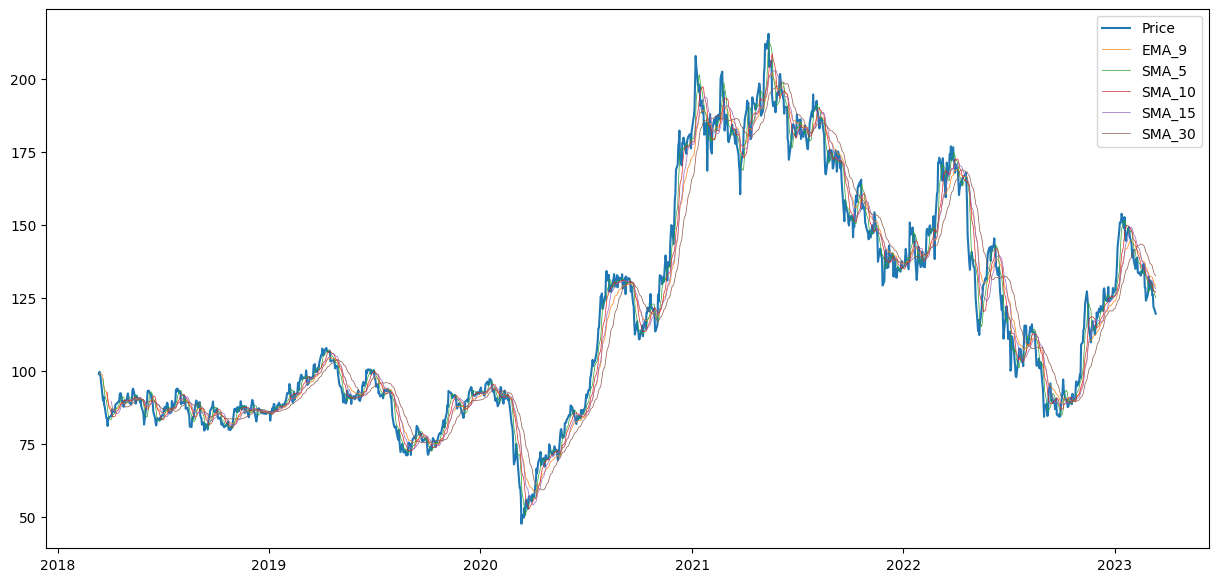

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))
dane_kgh = give_tf_df(spolki_interpolacja, 'kgh')
get_feature_plots(ax, dane_kgh, 'kgh')
plt.legend()
plt.show()

Funkcja get_best_arima znajduje najlepsze parametry modelu ARIMA, gdzie zmienne oznaczają:
p - ilość poprzednich wartości
d - ile razy należy różnicować, aby test adf potwierdzał stacjonarność
q - ilość poprzednich błędów

In [ ]:

def get_best_arima(train):
    model_autoARIMA = auto_arima(train, start_p=0, start_q=0,
                          test='adf',       # use adftest to find optimal 'd'
                          max_p=3, max_q=3, # maximum p and q
                          m=1,              # frequency of series
                          d=None,           # let model determine 'd'
                          seasonal=False,   # No Seasonality
                          start_P=0, 
                          D=0, 
                          trace=False,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)
    order = model_autoARIMA.get_params().get("order")
    return order


Funkcja get_arima_preds funkcja dopasowująca model ARIMA do zbioru treningowego i przewiduje wartość ceny dla okresu n+1, następnie dodaje do zbioru treningowego pierwszą wartość ze zbioru testowego, na nowo dopasowuje model i przewiduje kolejną watrość (okno rollujące). Na koniec zapisywane są przewidywania oraz obliczany jest błąd MAE.


In [ ]:

def get_arima_preds(order, train, test):
    """
    funkcja dopasowująca model ARIMA do zbioru treningowego i 
    przewidująca wartość ceny dla okresu n+1,
    następnie dodaje do zbioru treningowego pierwszą wartość z testowego (nie predykcję),
    na nowo dopasowuje model i przewiduje kolejną wartość (okno rollujące),
    przewidywania zapisujemy i obliczamy błąd MAE 
    
    źródło:     https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
    """
    history = [x for x in train]
    predictions = list()
    
    for t in range(len(test)):
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
    
    return predictions


Funkcja get_preds dzieli zbiór na testowy i treningowy i zwraca przewidywania dla modeli ARIMA oraz XGBoost, a także prawdziwe wartości dla zbioru testowego.
Model XGBoost jest algorytmem uczenia maszynowego bazującym na drzewach, który wykorzystuje strukturę wzmaciającą gradient.

In [ ]:
def get_preds(spolka, data):
    spolka_df = give_tf_df(data, spolka)
    y = spolka_df[spolka].copy()
    X = spolka_df.drop(spolka, axis=1).dropna()
    y, X = y.align(X, join='inner')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    arima_order = get_best_arima(y_train)
    arima_preds = get_arima_preds(arima_order, y_train, y_test)
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
    xgb_model.fit(X_train, y_train, verbose=False)
    xgb_preds = xgb_model.predict(X_test)
    predictions = {'arima': (arima_preds, arima_order), 'xgb': xgb_preds}
    return predictions, y_test


In [ ]:

def get_pred_plot(ax, predictions, y_test):
    ax.plot(y_test[-20:], label='Price')
    ax.plot(y_test[-20:].index, y_test[-20:].shift(1), linewidth=0.5, label='Naive')
    ax.plot(y_test[-20:].index, predictions['arima'][0][-20:], linewidth=0.5, label='ARIMA')
    ax.plot(y_test[-20:].index, predictions['xgb'][-20:], linewidth=0.5, label='XGBoost')

Funkcja get_mae zwraca wartości błędów prognozy dla trzech wybranych modeli - wspomnianych ARIMA oraz XGBoost, a także dla metody naiwnej, która polega na przypisywaniu wartości z ubieglego okresu do wartości z okresu bezpośrednio po nim następującego.


In [ ]:

def get_mae(predictions, y_test):
    print(f'MAE Naive: {mean_absolute_error(y_test.shift(1).dropna(), y_test[1:]):.6f}')
    print(f'MAE ARIMA {predictions["arima"][1]}: {mean_absolute_error(predictions["arima"][0], y_test):.6f}')
    print(f'MAE XGBoost: {mean_absolute_error(predictions["xgb"], y_test):.6f}')
    

In [ ]:
for i, spolka in enumerate(spolki_interpolacja.columns):
    print('\n' + spolka)
    predictions, y_true = get_preds(spolka, spolki_interpolacja)
    get_mae(predictions, y_true)


kgh
MAE Naive: 2.764141
MAE ARIMA (0, 1, 0): 2.767566
MAE XGBoost: 3.448540

lwb
MAE Naive: 1.138849
MAE ARIMA (1, 1, 0): 1.151599
MAE XGBoost: 1.385922

jsw
MAE Naive: 1.507412
MAE ARIMA (0, 1, 0): 1.507773
MAE XGBoost: 2.025872

gazp
MAE Naive: 3.993166
MAE ARIMA (1, 1, 1): 4.006212
MAE XGBoost: 5.727966

xom
MAE Naive: 1.542510
MAE ARIMA (0, 1, 0): 1.550273
MAE XGBoost: 15.275112


Błąd prognozy okazał się być najmniejszy dla wszystkich spółek dla najprostszej metody - naiwnej. Pokazuje to, że nie zawsze skomplikowane rozwiązaznia przynoszą najlepsze rezultaty.

XGBoost zwrócił zdecydowanie najgorsze wyniki dla każdej spółki. Błąd prognozy był zawsze znacząco wyższy. XGBoost nie został jeszcze odpowiednio wytrenowany, dlatego w kolejnym etapie metoda zostanie rozwinięta.

Mimo wszystko zarówno metoda naiwna, ARIMA jaki i XGBoost zwaracają dużo niższe błędy, aniżeli SVR wykorzystane we wstępnym modelowaniu.

Wytrenujmy teraz XGBoost na danych dla wszystkich analizowanych spółek 

Funkcja prepare_data przygtowuje jeden duży zbiór treningowy, złożony z danych dla wszystkich spółek, a także zwraca zbiór treningowy oraz scalery dla każdej spółki.

In [ ]:
def prepare_data(data): 
    """
    funkcja przygotowująca jeden duży zbiór treningowy
    złożony z danych dla wszystkich spółek
    zwraca zbiór treningowy oraz scalery dla każdej spółki
    """
    # tu będą scalery dla każdej spółki, aby móc je potem zastosować wobec danych testowych
    scalers = {}

    total_data = give_tf_df(data, 'kgh') # pierwsza spółka
    total_data = total_data.dropna()

    # zanim dokonamy standaryzacji podzielmy zbiór na treningowy i testowy, aby zapobiec przeciekowi informacji
    total_train, test = train_test_split(total_data, test_size=0.2, shuffle=False) 

    # standaryzacja aby indeksy spółek były w tych samych jednostkach
    scaler = StandardScaler()
    total_train = pd.DataFrame(scaler.fit_transform(total_train), columns=total_train.columns, index=total_train.index)
    scalers['kgh'] = scaler

    total_train.reset_index(inplace=True)
    total_train.rename(columns={'kgh': 'price'}, inplace=True)

    for i, spolka in enumerate(data.columns[1:]): # dołącz kolejne spółki
        
        spolka_df = give_tf_df(data, spolka)
        spolka_df = spolka_df.dropna()

        train, test = train_test_split(spolka_df, test_size=0.2, shuffle=False) 
        
        scaler = StandardScaler()
        train = pd.DataFrame(scaler.fit_transform(train), columns=train.columns, index=train.index)
        scalers[spolka] = scaler

        train.reset_index(inplace=True)
        train.rename(columns={spolka: 'price'}, inplace=True)

        total_train = pd.concat([total_train, train], ignore_index=True, axis=0)
        
    total_train.sort_values(by='Data', inplace=True)
    total_train.drop('Data', axis=1, inplace=True)

    return total_train, scalers

In [ ]:
total_training_data, training_scalers = prepare_data(spolki_interpolacja)
total_training_data

price       wti       lag     EMA_9     SMA_5    SMA_10    SMA_15  \
0    -0.690775  0.619506 -0.718567 -0.696130 -0.652781 -0.676356 -0.707096   
3060 -1.206072  0.619506 -1.206117 -1.227178 -1.207669 -1.208225 -1.227417   
2040  2.089160  0.619506  2.107976  2.096703  2.126583  2.110975  2.074793   
4080  0.990261  0.619506  1.071697  0.937183  1.043039  0.997351  0.929558   
1020  1.085575  0.619506  1.093013  1.177815  1.099991  1.221153  1.231066   
...        ...       ...       ...       ...       ...       ...       ...   
4079  0.560560  2.764157  0.535714  0.612900  0.487199  0.426074  0.364587   
2039  1.090135  2.764157  1.348383  0.959733  1.293812  1.505644  1.178284   
1019  1.168308  2.764157  1.295229  1.109628  1.168035  1.228579  1.198889   
3059  1.475195  2.764157  1.597034  1.067833  1.392528  1.411973  1.210455   
5099  1.011654  2.764157  1.032256  1.156374  1.101864  1.289326  1.221031   

        SMA_30       RSI      MACD  MACD_signal  
0    -0.685367  0.839898  0.031876    -0.681963  
3060 -1.231595  0.185744 -0.024417    -1.216388  
2040  2.125837  0.777255  0.056156     2.111803  
4080  0.829027  0.984413  0.712081     1.001096  
1020  1.170624  0.278017 -0.013259     1.149055  
...        ...       ...       ...          ...  
4079  0.927163  2.638215 -2.425171     0.490755  
2039  0.410283  0.717457  4.040027     1.235408  
1019  0.959059  0.182424  1.403582     1.186280  
3059  0.712593  1.124954  4.006427     1.357966  
5099  1.133047 -0.004029  0.458229     1.123859  

[5100 rows x 11 columns]

Wszystkie zmienne poddano standaryzacji, aby można było połączyć dane dla wszystkich spółek.

Teraz można nauczyć model na wyżej przedstawionych danych.

In [ ]:
%%time
y_train = total_training_data['price'].copy()
X_train = total_training_data.drop('price', axis=1).dropna()
y_train, X_train = y_train.align(X_train, join='inner')

xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
xgb_model.fit(X_train, y_train)

CPU times: user 2.32 s, sys: 0 ns, total: 2.32 s
Wall time: 1.33 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

Abyśmy mogli dokonać predykcji na zbiorze testowym, to musimy ponownie wobec danych każdej spółki zastosować standaryzację za pomocą scalerów wykorzystanych przy tworzeniu zbioru treningowego.

In [ ]:
def get_preds_new(spolka, data, scalers, xgb_model):
    """
    ta funkcja różni się od poprzedniej tym,
    że przyjmuje już wyliczone prognozy z modelu XGB
    """
    spolka_df = give_tf_df(data, spolka)

    y = spolka_df[spolka].copy()
    X = spolka_df.drop(spolka, axis=1).dropna()
    y, X = y.align(X, join='inner')
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False) # train, test i może da się łatwiej
    
    arima_order = get_best_arima(y_train)
    arima_preds = get_arima_preds(arima_order, y_train, y_test)

    # standaryzacja zbioru testowego, żeby móc dokonać predykcji za pomocą XGB
    test = pd.concat([y_test, X_test], axis=1)
    test = pd.DataFrame(scalers[spolka].transform(test), columns=test.columns, index=test.index)
    X_test = test.drop(spolka, axis=1)

    xgb_preds = xgb_model.predict(X_test)
    # złączenie, żeby odwrócić standaryzację
    X_test.insert(loc=0, column='price', value=xgb_preds)
    zlep = pd.DataFrame(scalers[spolka].inverse_transform(X_test), columns=X_test.columns, index=X_test.index)
    xgb_preds = zlep['price']
    
    predictions = {'arima': (arima_preds, arima_order), 'xgb': xgb_preds}
    
    return predictions, y_test

In [ ]:
for i, spolka in enumerate(spolki_interpolacja.columns):
    print('\n' + spolka)
    predictions, y_true = get_preds_new(spolka, spolki_interpolacja, training_scalers, xgb_model)
    get_mae(predictions, y_true)


kgh
MAE Naive: 2.764141
MAE ARIMA (0, 1, 0): 2.767566
MAE XGBoost: 2.997816

lwb
MAE Naive: 1.138849
MAE ARIMA (1, 1, 0): 1.151599
MAE XGBoost: 1.153193

jsw
MAE Naive: 1.507412
MAE ARIMA (0, 1, 0): 1.507773
MAE XGBoost: 1.589664

gazp
MAE Naive: 3.993166
MAE ARIMA (1, 1, 1): 4.006212
MAE XGBoost: 5.000516

xom
MAE Naive: 1.542510
MAE ARIMA (0, 1, 0): 1.550273
MAE XGBoost: 5.701430


Teraz sprawdźmy jak model będzie się sprawdzał po dostrojeniu hiperparametrów.

In [ ]:
total_training_data, training_scalers = prepare_data(spolki_interpolacja)

y_train = total_training_data['price'].copy()
X_train = total_training_data.drop('price', axis=1).dropna()
y_train, X_train = y_train.align(X_train, join='inner')

In [ ]:
%%time
# GRIDSEARCH

X_valid, X_test, y_valid, y_test = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)


parameters = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'max_depth': [8, 10, 12, 15],
    'gamma': [0.001, 0.005, 0.01, 0.02],
    'random_state': [42]
}

eval_set = [(X_valid, y_valid)]
model = xgb.XGBRegressor(objective='reg:squarederror', early_stopping_rounds=10)
clf = GridSearchCV(model, parameters, verbose=1)

clf.fit(X_train, y_train, eval_set=eval_set, verbose=False)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')


In [ ]:
%%time
# parametry znalezione po godzinnym dostrajaniu
xgb_model = xgb.XGBRegressor(gamma=0.01, learning_rate=0.05, max_depth=15, n_estimators=100, random_state= 42, objective='reg:squarederror')
xgb_model.fit(X_train, y_train)

CPU times: user 6.85 s, sys: 68.2 ms, total: 6.92 s
Wall time: 4.51 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.01, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [ ]:
for i, spolka in enumerate(spolki_interpolacja.columns):
    print('\n' + spolka)
    predictions, y_true = get_preds_new(spolka, spolki_interpolacja, training_scalers, xgb_model)
    get_mae(predictions, y_true)


kgh
MAE Naive: 2.764141
MAE ARIMA (0, 1, 0): 2.767566
MAE XGBoost: 3.191865

lwb
MAE Naive: 1.138849
MAE ARIMA (1, 1, 0): 1.151599
MAE XGBoost: 1.084645

jsw
MAE Naive: 1.507412
MAE ARIMA (0, 1, 0): 1.507773
MAE XGBoost: 1.522618

gazp
MAE Naive: 3.993166
MAE ARIMA (1, 1, 1): 4.006212
MAE XGBoost: 4.962697

xom
MAE Naive: 1.542510
MAE ARIMA (0, 1, 0): 1.550273
MAE XGBoost: 5.267393


XGBoost trenowany na danych dla wszystkich spółek przyniósł znacznie lepsze rezultaty. Błąd MAE obniżyl się, jednak w większości przypadków nadal jest wyższy aniżeli dla metody naiwnej oraz ARIMA. Metoda XGBoost sprawdziła sie najlepiej jedynie dla spółki Bogdanka.

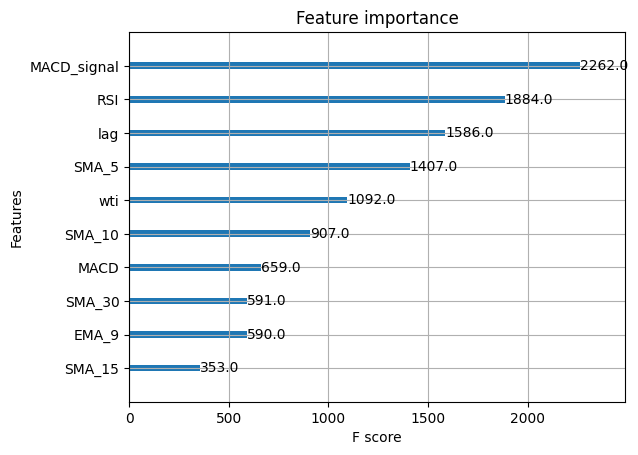

In [ ]:
# znaczenie cech w modelu XGBoost
from xgboost import plot_importance
plot_importance(xgb_model)
plt.show()

Sprawdzenie korelacji zmiennych

In [ ]:
plt.scatter(total_training_data['wti'], total_training_data['price'])
plt.show()

In [ ]:
plt.scatter(total_training_data['RSI'], total_training_data['price'])
plt.show()

In [ ]:
plt.scatter(total_training_data['MACD_signal'], total_training_data['price'])
plt.show()

In [ ]:
# import matplotlib.dates as mdates

# fig, ax = plt.subplots(5, 1, figsize=(15, 50))
# for i, spolka in enumerate(spolki_interpolacja.columns):
#     predictions, y_true = get_preds_new(spolka, spolki_interpolacja, xgb_model)    
#     get_pred_plot(ax[i], predictions, y_true)
#     ax[i].title(spolka)
#     ax[i].gca().xaxis.set_major_locator(mdates.DayLocator(interval=6))
# plt.grid()
# plt.legend()

In [ ]:
# wykresy dla wszystkich spółek

# fig, ax = plt.subplots(5, 1,figsize=(15,50))
# for i, spolka in enumerate(spolki_interpolacja.columns):
#     print(spolka)
#     predictions, y_test = get_preds(spolka, spolki_interpolacja)
#     get_pred_plot(ax[i], predictions, y_test)
#     plt.legend()